In [1]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
import numpy as np
import requests
from scipy import stats
from talib import MACD, RSI
from datetime import datetime, timedelta, date
from IPython.display import display, HTML
%matplotlib inline
import json
import math

In [2]:
start_day_to_analyze = '2020-02-12'
end_day_to_analyze = '2020-02-13'

In [3]:
base_url = "https://api.alpaca.markets"
api_key_id = "AKVKN4TLUUS5MZO5KYLM"
api_secret = "nkK2UmvE1kTFFw1ZlaqDmwCyiuCu7OOeB5y2La/X"

In [4]:
db_conn = create_engine("postgresql://momentum@localhost:5432/tradedb")

In [5]:
api = tradeapi.REST(
    base_url=base_url, key_id=api_key_id, secret_key=api_secret
)
session = requests.session()

In [6]:
query = f'''
SELECT * 
FROM 
trades as t
WHERE 
    buy_time >= '{start_day_to_analyze}' and 
    buy_time < '{end_day_to_analyze}' 
ORDER BY symbol, buy_time
'''
trades =  pd.read_sql_query(query, db_conn)

In [7]:
query = f'''
SELECT * 
FROM 
algo_run as t
WHERE 
    start_time >= '{start_day_to_analyze}' and 
    start_time < '{end_day_to_analyze}' 
'''
algo_runs = pd.read_sql_query(query, db_conn)

In [8]:
trade_details = {}

for index, row in trades.iterrows():
    algo_run_id = row['algo_run_id']
    symbol = row['symbol']
    buy_time = row['client_buy_time']
    buy_price = row['buy_price']
    sell_time = row['client_sell_time']
    sell_price = row['sell_price']
    buy_indicator = row['buy_indicators']
    sell_indicator = row['sell_indicators']
    qty = row['qty']    
    if algo_run_id not in trade_details:
        trade_details[algo_run_id] = {}
    if symbol not in trade_details[algo_run_id]:
        trade_details[algo_run_id][symbol] = []
    trade_details[algo_run_id][symbol].append((buy_time, buy_price, sell_time, sell_price, buy_indicator, sell_indicator, qty))

In [10]:
runs = trades['algo_run_id'].value_counts()
revenues = {}
how_was_my_day = {}
for run_id, count in runs.items():
    symbols = trades.loc[trades['algo_run_id'] == run_id]['symbol'].value_counts()
    revenues[run_id] = []
    precentages = []
    symbol_name = []
    counts = []
    for symbol, count in symbols.items():
        revnue = 0
        precentage = 0.0

        for trade in trade_details[run_id][symbol]:
            delta = trade[6] * (trade[3] - trade[1])
            precentage += 100.0 * delta / (trade[6] * trade[1])
            revnue += delta

        revenues[run_id].append(revnue)
        precentages.append(precentage)
        counts.append(count)
        symbol_name.append(symbol)


    d = {
        'symbol': symbol_name,
        'count': counts,
        'revenue': revenues[run_id],
        '%': precentages
    }
    how_was_my_day[run_id] = pd.DataFrame(data=d)

In [11]:
for algo_id, how_did_i_do in how_was_my_day.items():
    display(HTML(algo_runs.loc[algo_runs['algo_run_id'] == algo_id].to_html()))
    display(HTML(how_did_i_do.round(2).to_html()))
    print(f'TOTAL REVENUE: {pd.Series(revenues[algo_id]).sum().round(2)} $')

TOTAL REVENUE: -2114.83 $


In [12]:
minute_history = {}
for symbol, count in symbols.items():
    minute_history[symbol] = api.polygon.historic_agg_v2(
        symbol, 
        1, 
        'minute', 
        _from = start_day_to_analyze, 
        to=end_day_to_analyze, 
        limit=5000).df

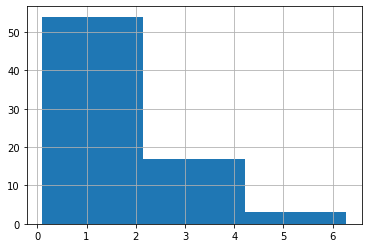

In [25]:
slopes = []
win = []
macd = []
macd_signal = []
bail_outs = []

for run_id, count in runs.items():
    for symbol in minute_history:
        for trade in trade_details[run_id][symbol]:
            if math.isnan(trade[3]):
                continue 
                
            min_time = trade_details[run_id][symbol][0][0]
            max_time = trade_details[run_id][symbol][-1][2]
            
            max_val = minute_history[symbol]['close'][min_time:max_time].max()
            max_val_index = minute_history[symbol]['close'][min_time:max_time].idxmax()
            
            macds = MACD(
                minute_history[symbol]["close"][:max_val_index]
                .dropna()
                .between_time("9:30", "16:00"),
                13,
                21,
            )
            
            macd_val = macds[0][-1].round(2)
            macd.append(macd_val)
            macd_signal_val = macds[1][-1].round(2)
            macd_signal.append(macd_signal_val)
            
            bail_out = ((max_val - trade[1]) / trade[1] > 0.003 and macd_val == macd_signal_val)
            bail_outs.append(bail_out)
            #if bail_out == True:
            #     print('bailout!!!')
            
            slope = 100.0 * (max_val - trade[1]) / trade[1]
            slopes.append(slope)
            win.append(trade[3] >= trade[1])
            #plt.scatter(slope, int(trade[3] >= trade[1]), c=('g' if win else 'r'), s=10)
            
#plt.show()           


d = {
    'slope': slopes,
    'macd': macd,
    'macd_signal': macd_signal,
    'count': win,
    'bail_outs': bail_outs
}
slope_analysis = pd.DataFrame(data=d)
display(HTML(slope_analysis.loc[slope_analysis['slope'] > 0].sort_values(by=['slope']).to_html()))
slope_analysis.loc[slope_analysis['slope'] > 0]['slope'].hist(bins=3)


MNK analysis for run 56


/Users/amichayoren/venv/algo/lib/python3.8/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


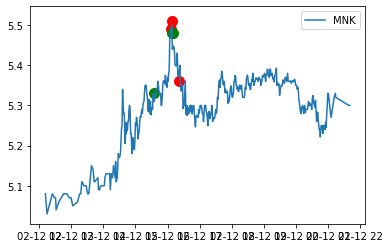

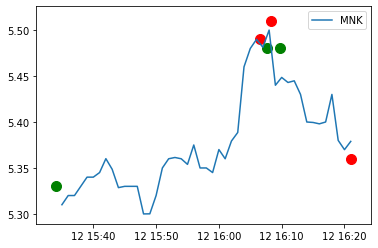

Delta = 0.0699999999999994


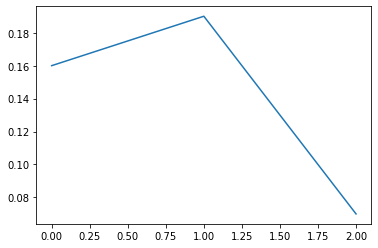

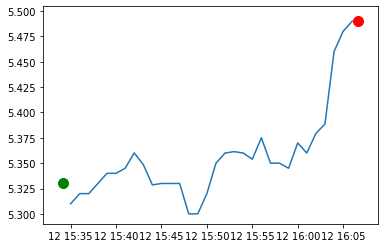

buy time:2020-02-12T15:34:07.398289486Z sell time:2020-02-12T16:06:35.385782452Z
{'rsi': 58.715499153922494, 'macd1': [0.010698646013573843, 0.00921198483834118, 0.0076071991900716895, 0.009454079959204442, 0.01079332751383344], 'macd2': [0.022160214384443044, 0.021724573436416428, 0.021221851279217496, 0.021365133530784064, 0.02146278723999373], 'macd_signal': [0.01794672030595431, 0.016199773212431684, 0.014481258407959685, 0.013475822718208637, 0.012939323677333598]}
{'rsi': 78.00730638143645, 'macd': [0.0074593663434452395, 0.00850295616187946, 0.012914805940375196, 0.01722384724906778, 0.020877335966893007], 'bail_out': 0, 'too_close': 0, 'macd_signal': [0.006583198829661196, 0.006967150296104849, 0.008156681424958918, 0.00997011458978069, 0.012151558865203154], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.008725777101689853}


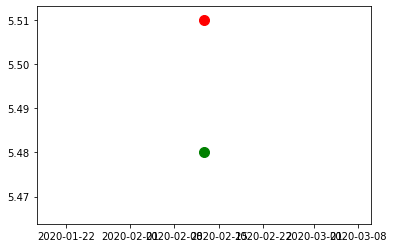

buy time:2020-02-12T16:07:38.733098426Z sell time:2020-02-12T16:08:14.372931837Z
{'rsi': 74.46494912090238, 'macd1': [0.014472528505726778, 0.02126344184979434, 0.027937081172356493, 0.033645065471544555, 0.03693599259516489], 'macd2': [0.019249672988769895, 0.020635886198671294, 0.022198114527814283, 0.023759847805401968, 0.024998755794409355], 'macd_signal': [0.012141345698790381, 0.013965764928991172, 0.016760028177664237, 0.0201370356364403, 0.02349682702818522]}
{'rsi': 78.01162884936039, 'macd': [0.012914805940375196, 0.01722384724906778, 0.020877335966893007, 0.0230011280071869, 0.02584822403849163], 'bail_out': 0, 'too_close': 0, 'macd_signal': [0.008156681424958918, 0.00997011458978069, 0.012151558865203154, 0.014321472693599903, 0.01662682296257825], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.00922140107591338}


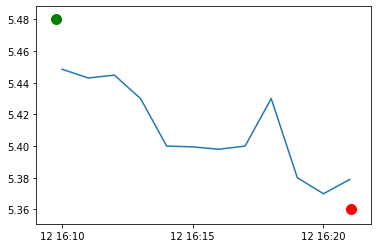

buy time:2020-02-12T16:09:46.77775333Z sell time:2020-02-12T16:21:03.512438586Z
{'rsi': 73.83305238246075, 'macd1': [0.027937081172356493, 0.033645065471544555, 0.037039696298868385, 0.04076894043652857, 0.042516138089264466], 'macd2': [0.022198114527814283, 0.023759847805401968, 0.025019547477735493, 0.026437576568550725, 0.02755758241888806], 'macd_signal': [0.016760028177664237, 0.0201370356364403, 0.02351756776892592, 0.02696784230244645, 0.03007750145981005]}
{'rsi': 42.97598208705588, 'macd': [0.007096724797908571, 0.007064602930155317, 0.004350422215929406, 0.0016543018903520945, -0.0004680555307512435], 'bail_out': 0, 'too_close': 1, 'macd_signal': [0.013609330265775958, 0.01230038479865183, 0.010710392282107345, 0.008899174203756296, 0.007025728256854788], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.007493783787606031}
ENDP analysis for run 56


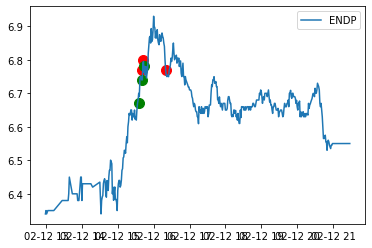

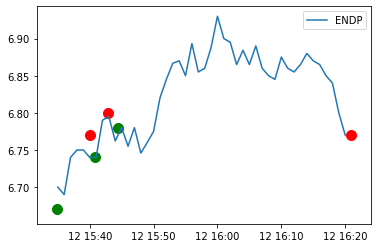

Delta = 0.14999999999999858


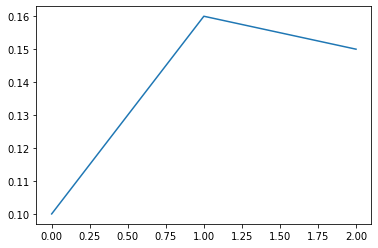

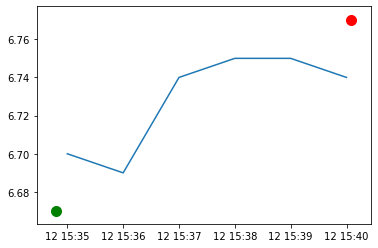

buy time:2020-02-12T15:34:48.234106069Z sell time:2020-02-12T15:40:05.166045367Z
{'rsi': 68.267085580101, 'macd1': [0.0448307928008882, 0.0415100100206498, 0.04082837097606795, 0.04142448430608425, 0.04181831116799373], 'macd2': [0.0387196551308886, 0.03875779161626092, 0.03921069880793482, 0.0398845479294101, 0.040520688927729864], 'macd_signal': [0.048968424666481124, 0.04747674173731486, 0.046147067585065475, 0.04520255092926923, 0.04452570297701413]}
{'rsi': 78.08334630125842, 'macd': [0.025434055599820482, 0.027708542540520575, 0.029640499344436577, 0.030760978680676843, 0.032751469349427076], 'bail_out': 0, 'too_close': 0, 'macd_signal': [0.025889529132523514, 0.026253331814122927, 0.026930765320185658, 0.027696807992283894, 0.02870774026371253], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.004043729085714546}


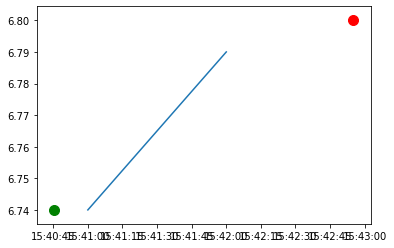

buy time:2020-02-12T15:40:45.348808666Z sell time:2020-02-12T15:42:55.061485098Z
{'rsi': 72.05722587717169, 'macd1': [0.044013584941880346, 0.04754842347723098, 0.050573742290087154, 0.05236766737377696, 0.05237866090232224], 'macd2': [0.042128811531108035, 0.04342635663071892, 0.04471062126393832, 0.04582067741587004, 0.04660874478729404], 'macd_signal': [0.04438263015539057, 0.04501578881975865, 0.046127379513824354, 0.047375437085814875, 0.04837608184911635]}
{'rsi': 78.42487213784194, 'macd': [0.029640499344436577, 0.030760978680676843, 0.030715105713063018, 0.030280463066700847, 0.03266541083490271], 'bail_out': 0, 'too_close': 0, 'macd_signal': [0.026930765320185658, 0.027696807992283894, 0.02830046753643972, 0.028696466642491945, 0.029490255480974097], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.003175155353928611}


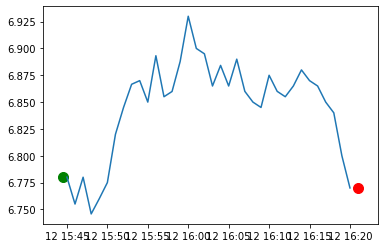

buy time:2020-02-12T15:44:29.481260092Z sell time:2020-02-12T16:20:57.652313952Z
{'rsi': 74.40945248954593, 'macd1': [0.05236766737377696, 0.05237866090232224, 0.05179036624916211, 0.0547278520194876, 0.05560790096182888], 'macd2': [0.04582067741587004, 0.04660874478729404, 0.04725924780308777, 0.04858182695067992, 0.049561006203301616], 'macd_signal': [0.047375437085814875, 0.04837608184911635, 0.0490589387291255, 0.05019272138719792, 0.051275757302124116]}
{'rsi': 36.59801644515848, 'macd': [0.008884348747564275, 0.007254157346976875, 0.005370187978376073, 0.001754495120007249, -0.0026441550958642424], 'bail_out': 0, 'too_close': 1, 'macd_signal': [0.01320830739302659, 0.012017477383816647, 0.010688019502728532, 0.008901314626184275, 0.006592220681774572], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.009236375777638814}
AXL analysis for run 56


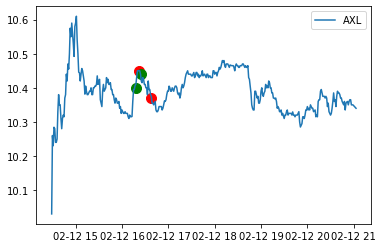

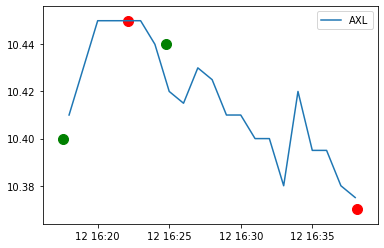

Delta = -0.02000000000000135


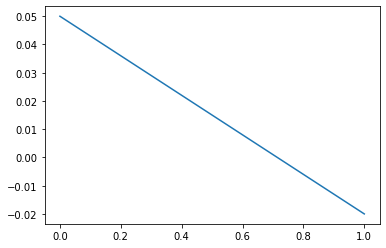

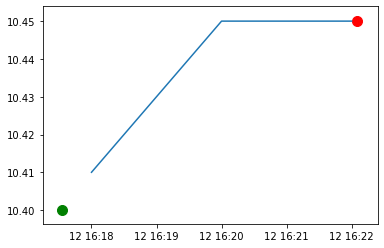

buy time:2020-02-12T16:17:32.960935562Z sell time:2020-02-12T16:22:05.390560901Z
{'rsi': 68.01993430603201, 'macd1': [-0.016231702044553487, -0.012034953928203862, -0.005817730145558642, -0.0008803869523674734, 0.0033967951728097745], 'macd2': [0.0007855536573018185, 0.0009275865231614944, 0.0016165538475334529, 0.0022478403721191142, 0.0029050170740720915], 'macd_signal': [-0.01713115931205254, -0.016111918235282803, -0.014053080617337971, -0.011418541884343872, -0.008455474472913142]}
{'rsi': 78.1000842104245, 'macd': [0.006128924662634816, 0.00905883333516222, 0.012263192906804221, 0.014600834223578829, 0.016492491948033816], 'bail_out': 0, 'too_close': 0, 'macd_signal': [-0.002324753543083931, -4.803616743470065e-05, 0.002414209647413084, 0.004851534562646233, 0.0071797260397237495], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.009312765908310067}


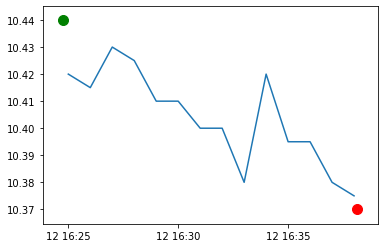

buy time:2020-02-12T16:24:44.475163369Z sell time:2020-02-12T16:38:09.194511012Z
{'rsi': 71.34876791851431, 'macd1': [0.017639589092407704, 0.0214156229306397, 0.024130001317509198, 0.025981665280811583, 0.026338591003845835], 'macd2': [0.006008836399548301, 0.007136839639930059, 0.008163224325080876, 0.009094475130051904, 0.009776774291076151], 'macd_signal': [0.002282107834828227, 0.006108810853990522, 0.009713048946694256, 0.012966772213517722, 0.015641135971583345]}
{'rsi': 43.010131320279946, 'macd': [0.0051325953190488605, 0.003950708703582606, 0.002978450188887649, 0.0014029442009579896, -0.00010268311692129828], 'bail_out': 0, 'too_close': 1, 'macd_signal': [0.008634276647307194, 0.007697563058562276, 0.006753740484627351, 0.0056835812278934784, 0.004526328358930523], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.004629011475851821}
VAL analysis for run 56


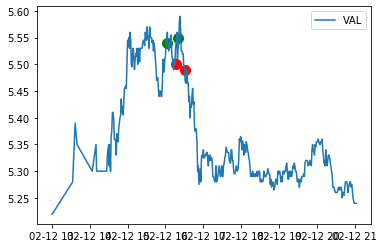

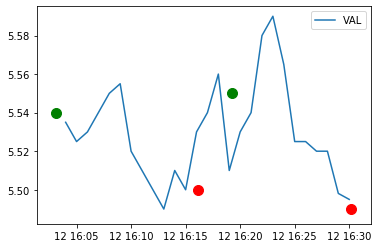

Delta = -0.09999999999999964


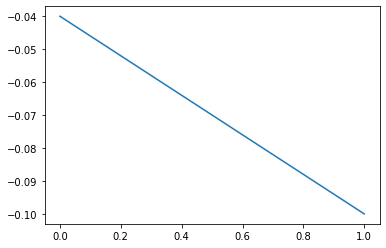

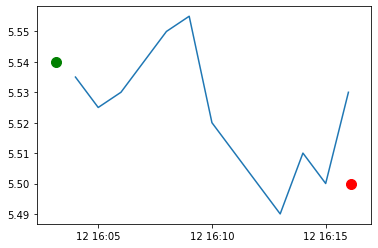

buy time:2020-02-12T16:03:09.406777185Z sell time:2020-02-12T16:16:07.556237946Z
{'rsi': 61.94790885002522, 'macd1': [-0.01257576454594389, -0.009029171262042723, -0.005748744372810144, -0.0007199341960850703, 0.003228221175378465], 'macd2': [0.018702611540383884, 0.01840780071851711, 0.018187092640152613, 0.018434754511853058, 0.01863312754213542], 'macd_signal': [-0.015591073157806732, -0.01427869277865393, -0.012572703097485174, -0.010202149317205153, -0.007516075218688429]}
{'rsi': 46.39901717905941, 'macd': [0.0038254657246410417, 0.0018240467960630724, 0.0012797716985204488, 0.0003195603017527304, -0.00043280650484156524], 'bail_out': 0, 'too_close': 1, 'macd_signal': [0.0049375850676547164, 0.004314877413336388, 0.0037078562703731998, 0.003030197076649106, 0.0023375963603509717], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.002770402865192537}


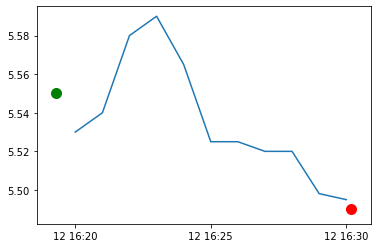

buy time:2020-02-12T16:19:17.809706391Z sell time:2020-02-12T16:30:11.217813068Z
{'rsi': 57.57126407162556, 'macd1': [0.0007582531802441395, 0.0020018907592893598, 0.003751157913705505, 0.0066743597251290865, 0.008090835677382557], 'macd2': [0.014825191908856006, 0.01467457090654456, 0.014672460866582249, 0.014966925062736003, 0.015053968011596197], 'macd_signal': [0.004750443002201696, 0.004200732553619229, 0.004110817625636485, 0.004623526045535005, 0.005316987971904516]}
{'rsi': 42.70459628089948, 'macd': [0.005438577085551621, 0.0039080160683253595, 0.0026646176644051778, 0.0005234680293453309, -0.001312797504848362], 'bail_out': 0, 'too_close': 1, 'macd_signal': [0.005699043069209574, 0.005340837669032731, 0.004805593668107221, 0.003949168540354843, 0.0028967753313142016], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.004209572836162564}
WETF analysis for run 56


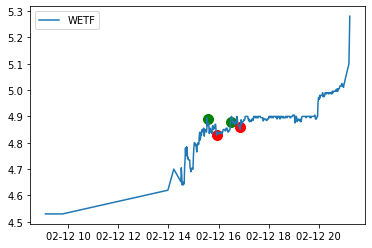

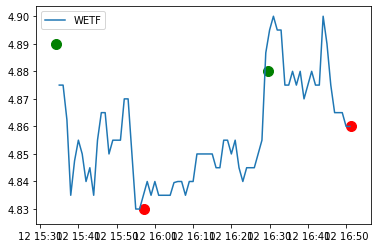

Delta = -0.07999999999999918


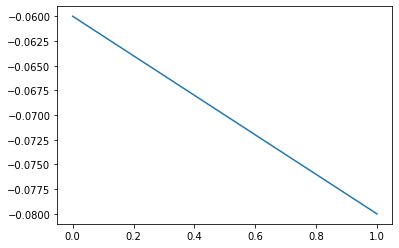

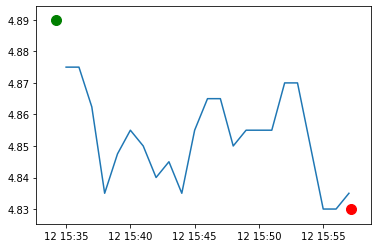

buy time:2020-02-12T15:34:13.809538532Z sell time:2020-02-12T15:57:09.762789165Z
{'rsi': 67.87760753733872, 'macd1': [0.023861251942176587, 0.022153605237668295, 0.02136096345792282, 0.024086261625268612, 0.025548119031305383], 'macd2': [0.04624888265239857, 0.04561896682014144, 0.04512639896836035, 0.04532075953500403, 0.045347125239005415], 'macd_signal': [0.027356102361856163, 0.026315602937018588, 0.025324675041199434, 0.02507699235801327, 0.025171217692671694]}
{'rsi': 43.67603517282813, 'macd': [0.004110404500116793, 0.0033216713136736686, 0.0016249743980862874, 0.00028176934180912383, -0.0007685432908974832], 'bail_out': 0, 'too_close': 1, 'macd_signal': [0.004233757089040492, 0.004051339933967128, 0.0035660668267909596, 0.0029092073297945923, 0.0021736572056561773], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0029422004965536605}


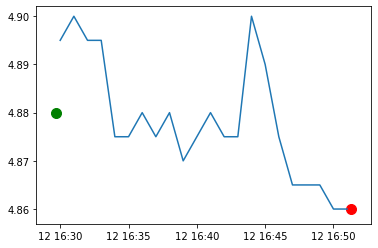

buy time:2020-02-12T16:29:42.634754649Z sell time:2020-02-12T16:51:17.195220305Z
{'rsi': 71.11385424192277, 'macd1': [0.0008179678619759656, 0.000623712577668023, 0.0008632708298179637, 0.0014399814737560135, 0.003869712246370227], 'macd2': [0.013000210212546826, 0.012613723478367866, 0.012317937445077476, 0.01210607202629177, 0.012291627157547502], 'macd_signal': [0.0013859762376260028, 0.0012335235056344068, 0.0011594729704711181, 0.0012155746711280972, 0.0017464021861765232]}
{'rsi': 43.999307172841476, 'macd': [0.0028217112750690276, 0.00191226632146968, 0.001178773288517121, 0.0003321712720794068, -0.00033183252348401027], 'bail_out': 0, 'too_close': 1, 'macd_signal': [0.0041227907864126055, 0.0036806858934240205, 0.0031803033724426407, 0.0026106769523699938, 0.002022175057199193], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0023540075806832033}
AGRX analysis for run 56


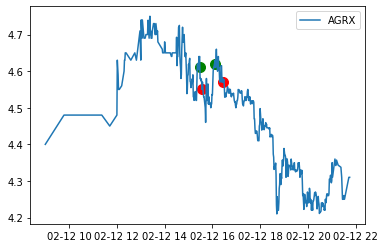

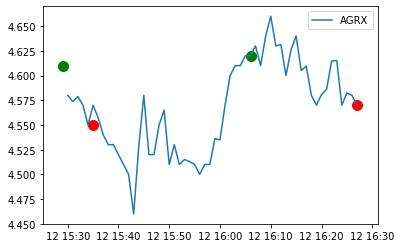

Delta = -0.11000000000000032


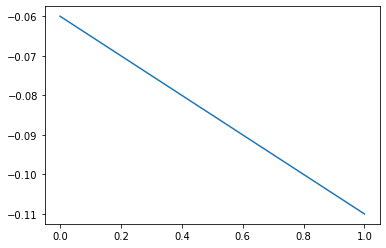

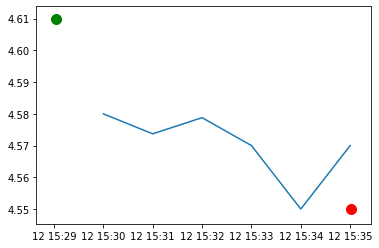

buy time:2020-02-12T15:29:02.139537672Z sell time:2020-02-12T15:35:01.163340723Z
{'rsi': 60.735869399108736, 'macd1': [-0.003996767366589715, -0.0005365599982933844, 0.0020927940366783915, 0.007008751824343129, 0.010381553489045459], 'macd2': [0.011480056972145825, 0.011675787663984138, 0.01181959940779187, 0.012510376067075946, 0.013045936078569298], 'macd_signal': [-0.013270787665186665, -0.01072394213180801, -0.008160594898110728, -0.005126725553619957, -0.0020250697450868733]}
{'rsi': 42.7619422208021, 'macd': [0.00494138387958909, 0.0036856187279523667, 0.0029241703146256626, 0.0018357147936622908, -7.523385635632707e-05], 'bail_out': 0, 'too_close': 1, 'macd_signal': [0.0012590570258376537, 0.0017443693662605962, 0.0019803295559336093, 0.0019514066034793456, 0.001546078511512211], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0016213123678685381}


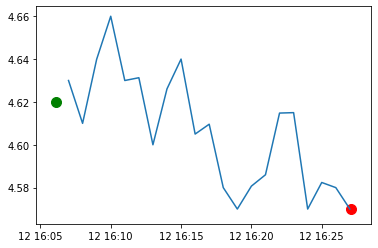

buy time:2020-02-12T16:06:07.838122462Z sell time:2020-02-12T16:27:05.354926931Z
{'rsi': 65.45877351457683, 'macd1': [0.002282245545628392, 0.00767110755358047, 0.011805730408202209, 0.015708289848054946, 0.018586838812634454], 'macd2': [-0.0023243415606639672, -0.001167765332921178, -0.00010181053029523213, 0.0010390008423408759, 0.0020869220598811467], 'macd_signal': [-0.007148903939767767, -0.0041849016410981195, -0.0009867752312380535, 0.002352237784620546, 0.005599157990223327]}
{'rsi': 45.43327173218486, 'macd': [0.004124201071999067, 0.002063225484657316, 0.0010746311895255545, 0.00016566639865001065, -0.0010642498851316518], 'bail_out': 0, 'too_close': 1, 'macd_signal': [0.006822362449295401, 0.005870535056367783, 0.004911354282999337, 0.003962216706129472, 0.002956923387877247], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.004021173273008899}
APPS analysis for run 56


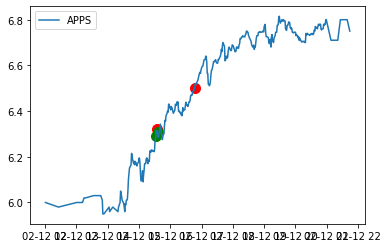

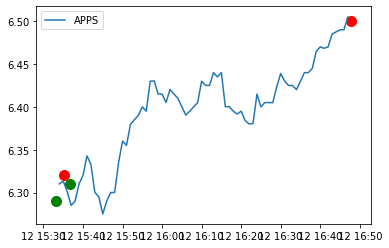

Delta = 0.22000000000000064


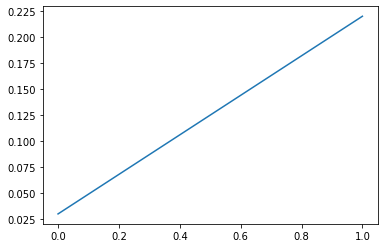

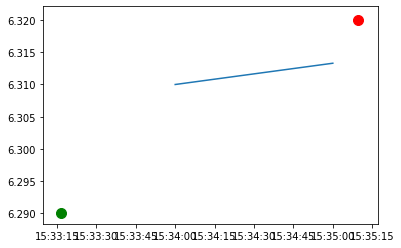

buy time:2020-02-12T15:33:16.434447511Z sell time:2020-02-12T15:35:09.59154535Z
{'rsi': 74.42241700706211, 'macd1': [0.023157912273291004, 0.022958707559893377, 0.025731880988884903, 0.02857659657013034, 0.031109902548939417], 'macd2': [0.03086165558087295, 0.03088572572770598, 0.03149821773288419, 0.03220487556294582, 0.032929865632805644], 'macd_signal': [0.021644088068978343, 0.021907011967161348, 0.02267198577150606, 0.023852907931230915, 0.025304306854772616]}
{'rsi': 78.1130804179088, 'macd': [0.013285796988766307, 0.015084219921638997, 0.01691826090931059, 0.01983675699179077, 0.022113029822401487], 'bail_out': 0, 'too_close': 0, 'macd_signal': [0.012561799395495888, 0.01306628350072451, 0.013836678982441727, 0.015036694584311536, 0.016451961631929527], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.005661068190471959}


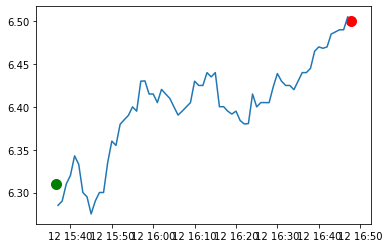

buy time:2020-02-12T15:36:36.844319447Z sell time:2020-02-12T16:47:49.618790387Z
{'rsi': 74.60166947102826, 'macd1': [0.02857659657013034, 0.0331042045432417, 0.0358753594561545, 0.03790090408073077, 0.03880067945234256], 'macd2': [0.03220487556294582, 0.03332970569678029, 0.034231311180652924, 0.035058847755490063, 0.03571295661901708], 'macd_signal': [0.023852907931230915, 0.025703167253633072, 0.027737605694137357, 0.02977026537145604, 0.031576348187633344]}
{'rsi': 78.18028578449817, 'macd': [0.011544478641551947, 0.012351562160670682, 0.012949918641013802, 0.013247989682307448, 0.01382768153679148], 'bail_out': 0, 'too_close': 0, 'macd_signal': [0.008540618451039782, 0.009302807192965962, 0.01003222948257553, 0.010675381522521914, 0.011305841525375827], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.002521840011415654}
IO analysis for run 56


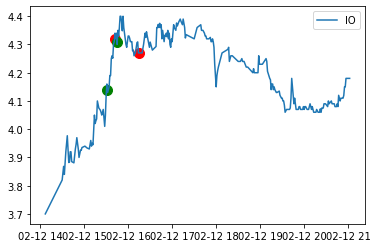

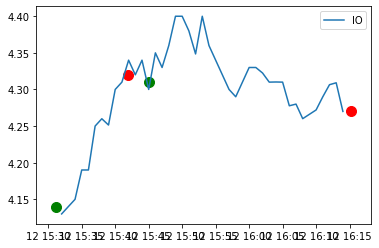

Delta = 0.14000000000000057


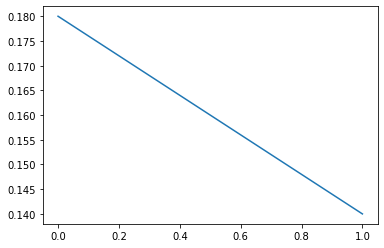

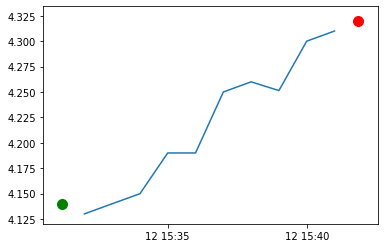

buy time:2020-02-12T15:31:12.04218188Z sell time:2020-02-12T15:41:50.475697023Z
{'rsi': 68.40828448740699, 'macd1': [0.05771255551453214, 0.05132902545629925, 0.04893362127442158, 0.052147095248455066, 0.05560212932784481], 'macd2': [0.06595058597079761, 0.0651919658287361, 0.0650294896951098, 0.06590834793491274, 0.06691859160466329], 'macd_signal': [0.05942758327382118, 0.057807871710316795, 0.05603302162313775, 0.055255836348201214, 0.05532509494412993]}
{'rsi': 78.0188767419014, 'macd': [0.040878469300563935, 0.043597856545460445, 0.044703900417516707, 0.0475098579747355, 0.05011826830536492], 'bail_out': 0, 'too_close': 0, 'macd_signal': [0.03546260442935897, 0.037089654852579264, 0.03861250396556675, 0.0403919747674005, 0.04233723347499339], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.007781034830371535}


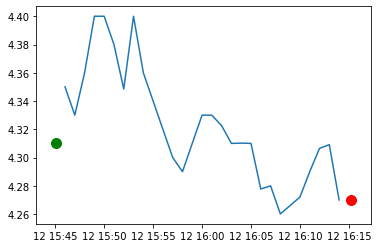

buy time:2020-02-12T15:45:05.772691754Z sell time:2020-02-12T16:15:14.915739562Z
{'rsi': 74.90386572880097, 'macd1': [0.07605228240481043, 0.08046417010239892, 0.08380152747113723, 0.08785442538144661, 0.08843314111879508], 'macd2': [0.07566530006755023, 0.07743518338196242, 0.07909962191572317, 0.08098425789274044, 0.08226878822122785], 'macd_signal': [0.06660209279802846, 0.06937450825890255, 0.0722599121013495, 0.07537881475736892, 0.07798968002965415]}
{'rsi': 46.37532990429933, 'macd': [0.0011528702271865754, 0.0005820745510369818, 0.0009868821468819178, 0.0014245649209572164, -0.000284053241074389], 'bail_out': 0, 'too_close': 1, 'macd_signal': [0.011682227579572461, 0.009462196973865366, 0.0077671340084686765, 0.006498620190966384, 0.00514208550455823], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.005426138745632619}
WKHS analysis for run 56


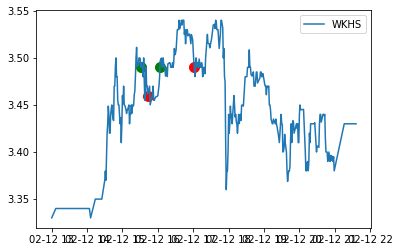

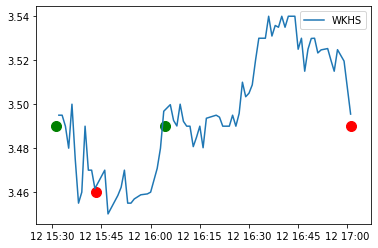

Delta = -0.03000000000000025


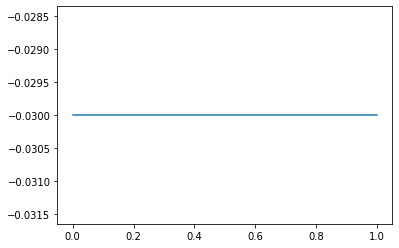

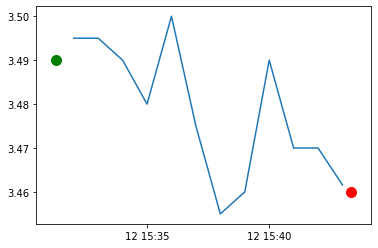

buy time:2020-02-12T15:31:16.308636339Z sell time:2020-02-12T15:43:21.192430156Z
{'rsi': 67.3728079388921, 'macd1': [0.014313352250101996, 0.015155052844533223, 0.0156417977222838, 0.015805010401749087, 0.016494649846894305], 'macd2': [0.016720789446940998, 0.016967076035038442, 0.017166531107038807, 0.017314583884425083, 0.0175718454219016], 'macd_signal': [0.009528833146429345, 0.01065407708605012, 0.011651621213296857, 0.012482299050987303, 0.013284769210168704]}
{'rsi': 45.60836139692977, 'macd': [0.0018006027300687677, 0.002207907496481365, 0.001457652671653431, 0.0008541079682595765, -8.442177423217956e-05], 'bail_out': 0, 'too_close': 1, 'macd_signal': [0.005402143055392465, 0.0047632959436102445, 0.004102167289218882, 0.003452555425027021, 0.0027451599851751806], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.00282958175940736}


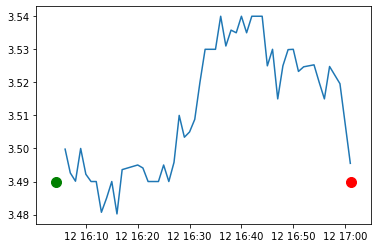

buy time:2020-02-12T16:04:18.649084703Z sell time:2020-02-12T17:01:09.36100823Z
{'rsi': 60.00128425391604, 'macd1': [-0.0040953603781765935, -0.003953284066796403, -0.0029353805856087156, -0.0013705230936742474, 0.0006688441503617248], 'macd2': [0.00888133719684392, 0.008526870555505273, 0.008359843276839474, 0.008339943580191633, 0.008468232674030851], 'macd_signal': [-0.0024694928776906296, -0.002766251115511784, -0.0028000770095311703, -0.002514166226359786, -0.0018775641510154837]}
{'rsi': 33.80113023522397, 'macd': [0.0014090322887057027, 0.0007235038772241964, 0.0006890206490930417, 0.00038307241095036915, -0.0013979661176146685], 'bail_out': 0, 'too_close': 1, 'macd_signal': [0.0031084237083076082, 0.0026314397420909258, 0.002242955923491349, 0.001870979220983153, 0.0012171901532635888], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0026151562708782573}
NIO analysis for run 56


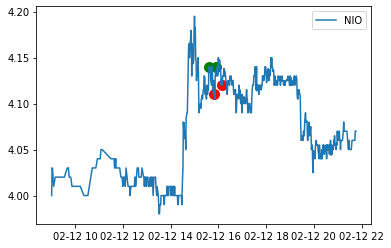

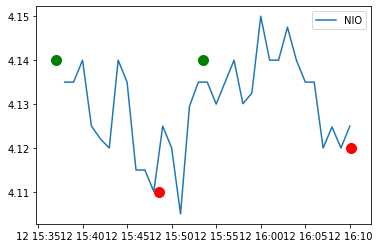

Delta = -0.049999999999998934


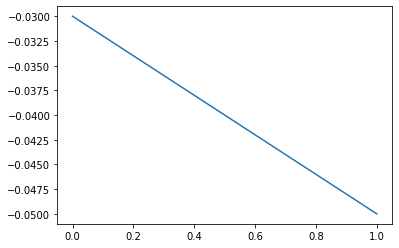

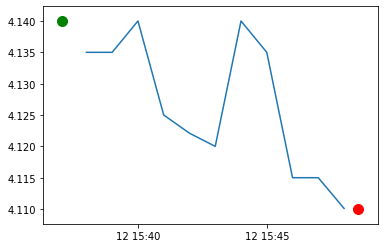

buy time:2020-02-12T15:37:03.75807568Z sell time:2020-02-12T15:48:31.785555905Z
{'rsi': 59.6275194616438, 'macd1': [-0.002074984585473061, -0.0016455169034390593, -0.0015056716607801945, 0.00021649394712319747, 0.0019621622274224038], 'macd2': [0.012793361831789696, 0.012458000701226268, 0.012086350175743554, 0.012044961427307044, 0.012067586235040118], 'macd_signal': [-0.002016129045861688, -0.0019420066173771622, -0.0018547396260577688, -0.0014404929114215756, -0.0007599618836527797]}
{'rsi': 43.83721443288831, 'macd': [0.00216868187475594, 0.002374981877366622, 0.0014659301667085956, 0.0007385401302641981, -9.239418553974588e-05], 'bail_out': 0, 'too_close': 1, 'macd_signal': [0.0015095413317444198, 0.0016826294408688602, 0.0016392895860368073, 0.0014591396948822855, 0.0011488329187978792], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.001241227104337625}


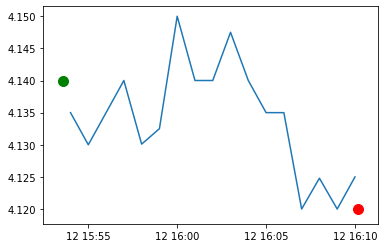

buy time:2020-02-12T15:53:33.641645032Z sell time:2020-02-12T16:10:08.632028197Z
{'rsi': 56.643685531144946, 'macd1': [0.0002761355204166094, 2.063771817706339e-05, -0.0013763550068626174, -0.0005007640648635459, 0.0010285537850203141], 'macd2': [0.009219801288589125, 0.00892096653742147, 0.008391857129748992, 0.008283481209887533, 0.00833845645321496], 'macd_signal': [0.001649160905856422, 0.0013234562683205502, 0.0007834940132839166, 0.0005266423976544242, 0.0006270246751276022]}
{'rsi': 44.62512887244937, 'macd': [0.0025245479661863968, 0.0014447021393868553, 0.0008338521166946222, 9.768518840580498e-05, -0.00047722001790351243], 'bail_out': 0, 'too_close': 1, 'macd_signal': [0.002573463585917054, 0.002347711296611014, 0.0020449394606277356, 0.0016554886061833495, 0.001228946881365977], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0017061668992694894}
RTIX analysis for run 56


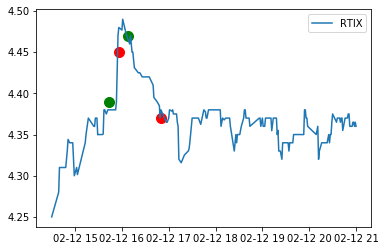

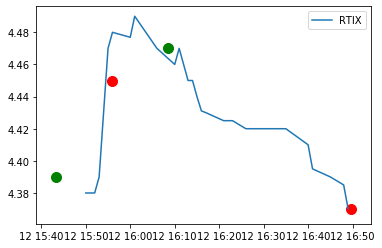

Delta = -0.03999999999999915


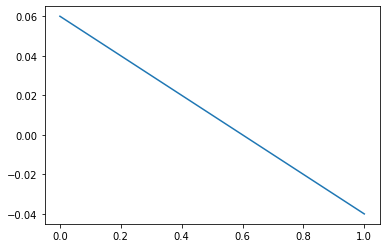

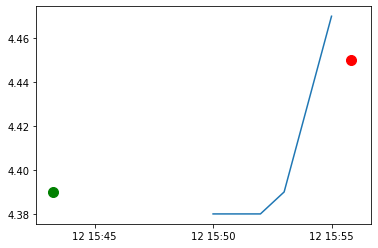

buy time:2020-02-12T15:43:15.819350139Z sell time:2020-02-12T15:55:50.148123688Z
{'rsi': 67.7660433236135, 'macd1': [0.020247486631141065, 0.020923881354340423, 0.020816511050814945, 0.02089402421983877, 0.02151436617027258], 'macd2': [0.012189773432942808, 0.012776605669646557, 0.013216107690428913, 0.013679294303406309, 0.014243498709342717], 'macd_signal': [0.02060008222873596, 0.020664842053856852, 0.02069517585324847, 0.02073494552656653, 0.020890829655307742]}
{'rsi': 78.5628859913714, 'macd': [0.01193587396901652, 0.011565772282532194, 0.011646657042642339, 0.01363635092009563, 0.01552914678668138], 'bail_out': 0, 'too_close': 0, 'macd_signal': [0.012318172241463386, 0.012167692249677148, 0.012063485208270186, 0.012378058350635275, 0.013008276037844496], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0025208707488368846}


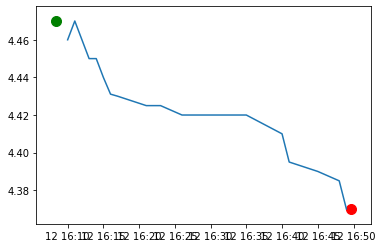

buy time:2020-02-12T16:08:23.243358596Z sell time:2020-02-12T16:49:39.435190109Z
{'rsi': 73.54730429657135, 'macd1': [0.02841252281223472, 0.03307641186082577, 0.036106223373416846, 0.039113554634012004, 0.03942854573978849], 'macd2': [0.01766389441685501, 0.01920143761594506, 0.020535736356706025, 0.02194000603166213, 0.022877017026443625], 'macd_signal': [0.02241852877044727, 0.02455010538852297, 0.026861328985501746, 0.029311774115203797, 0.031335128440120735]}
{'rsi': 31.985253109714982, 'macd': [0.0030933055936728238, 0.001208762306968758, -0.0005351514528912915, -0.002146835532615299, -0.00415403305535289], 'bail_out': 0, 'too_close': 1, 'macd_signal': [0.00838859146731987, 0.006952625635249647, 0.005455070217621459, 0.003934689067574108, 0.002316944642988708], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.006470977698341598}
FSP analysis for run 56


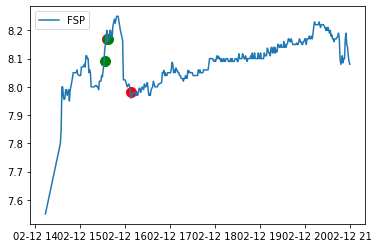

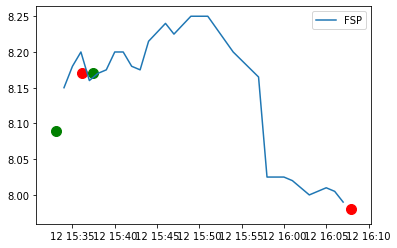

Delta = -0.10999999999999943


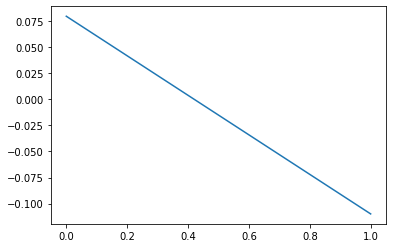

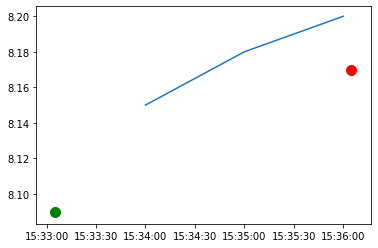

buy time:2020-02-12T15:33:05.091232571Z sell time:2020-02-12T15:36:04.784758527Z
{'rsi': 69.06629978456593, 'macd1': [0.003705980841806067, 0.004770407764093321, 0.007544298854043063, 0.011227042028744805, 0.014782159421701024], 'macd2': [0.04570911481116546, 0.044973382559327924, 0.04462439677695418, 0.04455182025862214, 0.04457372915517599], 'macd_signal': [0.008039628564280357, 0.007385784404242949, 0.007417487294202972, 0.008179398241111338, 0.009499950477229275]}
{'rsi': 78.100517474039, 'macd': [0.0023577089657766948, 0.004915699613858848, 0.009442501422574523, 0.013886210605695837, 0.017687981260001706], 'bail_out': 0, 'too_close': 0, 'macd_signal': [0.0014355761512546727, 0.002131600843775508, 0.003593780959535311, 0.005652266888767417, 0.008059409763014275], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.009628571496987431}


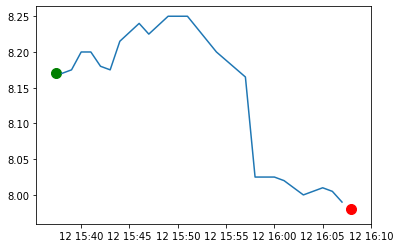

buy time:2020-02-12T15:37:25.206426432Z sell time:2020-02-12T16:07:57.503566702Z
{'rsi': 74.88704099571507, 'macd1': [0.017973042612585033, 0.024648991302344214, 0.03199169763987797, 0.038975394085071, 0.042407345498425286], 'macd2': [0.045213473257534886, 0.04606977459998607, 0.047263725136002854, 0.0486064781479314, 0.049444242549312456], 'macd_signal': [0.010138127115406077, 0.013040299952793705, 0.016830579490210558, 0.021259542409182645, 0.025489103027031175]}
{'rsi': 29.55795369023313, 'macd': [-0.004310819167796964, -0.010887364933704902, -0.015351071180729647, -0.018889659539700787, -0.02270038216305892], 'bail_out': 0, 'too_close': 0, 'macd_signal': [0.014971489081473766, 0.009799718278438032, 0.004769560386604496, 3.7716401343438656e-05, -0.004509903311537033], 'data.close <= stop_prices': 1, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.018190478851521884}
HMY analysis for run 56


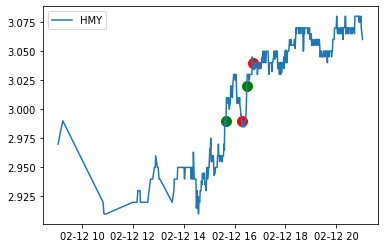

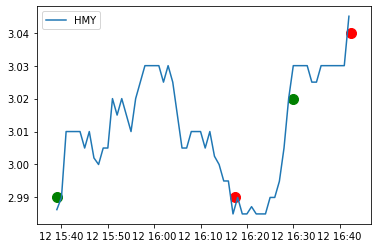

Delta = 0.020000000000000018


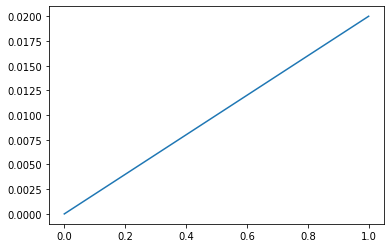

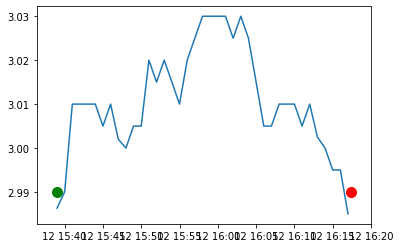

buy time:2020-02-12T15:38:56.77184843Z sell time:2020-02-12T16:17:25.551488535Z
{'rsi': 72.23076041397705, 'macd1': [0.0031334927127648626, 0.0038271860884657727, 0.003928202994345931, 0.005956883442037153, 0.007478420733623814], 'macd2': [0.01361675596102252, 0.013518725470900606, 0.01332694495924347, 0.013529026231870578, 0.013693309679846166], 'macd_signal': [0.0038621008227274233, 0.0038551178758750933, 0.0038697348995692608, 0.004287164608062839, 0.004925415833175034]}
{'rsi': 35.51558584215014, 'macd': [-1.5066057356794005e-05, -0.0005963433101969784, -0.0013012821655249418, -0.001833685401292584, -0.0024844712291467452], 'bail_out': 0, 'too_close': 1, 'macd_signal': [0.002125756078530085, 0.0015813362007846723, 0.0010048125275227493, 0.00043711294175968263, -0.00014720389242160303], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.002337267336725142}


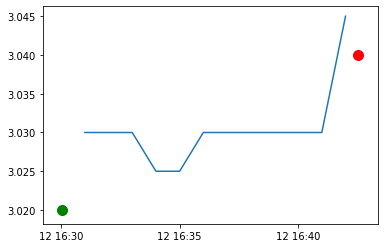

buy time:2020-02-12T16:30:02.681032773Z sell time:2020-02-12T16:42:30.510057101Z
{'rsi': 67.58840232841733, 'macd1': [-0.0056813358873832875, -0.004915045012458652, -0.003452964754184773, -0.0010715290560590063, 0.0008064793006612447], 'macd2': [0.0062430868582010746, 0.006018048434289547, 0.005962916244302896, 0.006142560053124857, 0.0062980139371253685], 'macd_signal': [-0.005033748935271702, -0.005010008150709093, -0.0046985994714042285, -0.003973185388335184, -0.0030172524505358983]}
{'rsi': 78.30098840849347, 'macd': [0.005222861808947599, 0.0052151401761948435, 0.0051413942263072165, 0.005017158496182894, 0.005634414310421665], 'bail_out': 0, 'too_close': 0, 'macd_signal': [0.0035742631867691746, 0.0039024385846543083, 0.00415022971298489, 0.004323615469624491, 0.004585775237783926], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0010486390726377392}
HSC analysis for run 56


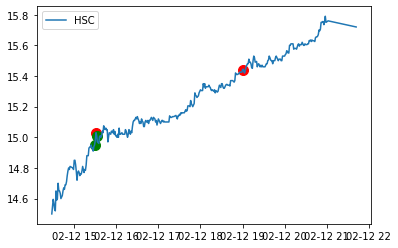

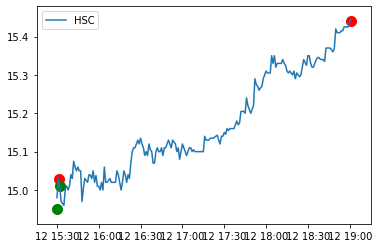

Delta = 0.5099999999999998


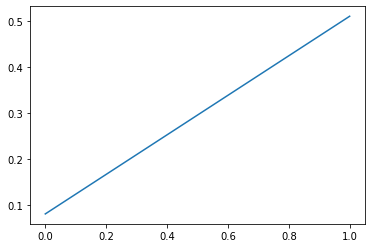

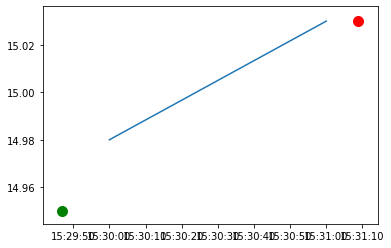

buy time:2020-02-12T15:29:46.772647583Z sell time:2020-02-12T15:31:08.775816377Z
{'rsi': 71.68159122589044, 'macd1': [0.054384673771176395, 0.055174754163880735, 0.055164990891338306, 0.05532640153659507, 0.0556200833636602], 'macd2': [0.0723557767696299, 0.07265613715093266, 0.0728162749713146, 0.07300708345784557, 0.07322580476679086], 'macd_signal': [0.04345839985952625, 0.04580167072039715, 0.04767433475458538, 0.049204748110987316, 0.05048781516152189]}
{'rsi': 78.21448710648009, 'macd': [0.03199520947293699, 0.03209204814501376, 0.03227020752396825, 0.0335483809682966, 0.03618658909415906], 'bail_out': 0, 'too_close': 0, 'macd_signal': [0.026872386271364936, 0.0279163186460947, 0.028787096421669413, 0.02973935333099485, 0.031028800483627692], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0051577886105313685}


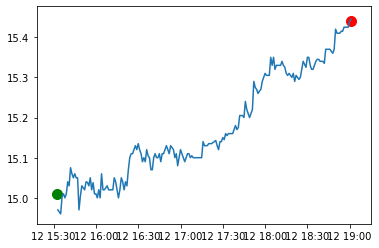

buy time:2020-02-12T15:32:07.301745927Z sell time:2020-02-12T19:01:06.404885411Z
{'rsi': 73.71081013214433, 'macd1': [0.05532640153659507, 0.0556200833636602, 0.057609491252515355, 0.0625002297266608, 0.06402430995880692], 'macd2': [0.07300708345784557, 0.07322580476679086, 0.07378972900222358, 0.07499022110527065, 0.07565490381006512], 'macd_signal': [0.049204748110987316, 0.05048781516152189, 0.051912150379720585, 0.05402976624910863, 0.056028674991048286]}
{'rsi': 78.22625771727981, 'macd': [0.01499902525297081, 0.015171594398140087, 0.015109030168426685, 0.015643278428800755, 0.016121351379366544], 'bail_out': 0, 'too_close': 0, 'macd_signal': [0.012753241881353086, 0.013236912384710486, 0.013611335941453726, 0.014017724438923133, 0.014438449827011816], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0016829015523547285}
TLRD analysis for run 56


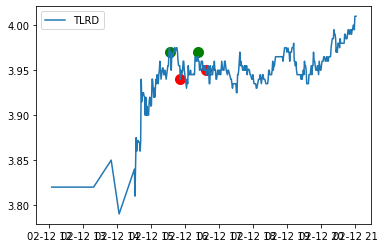

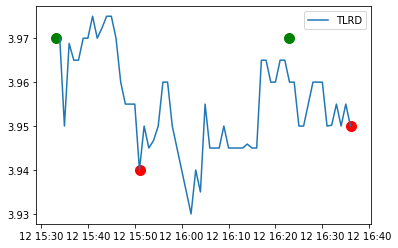

Delta = -0.050000000000000266


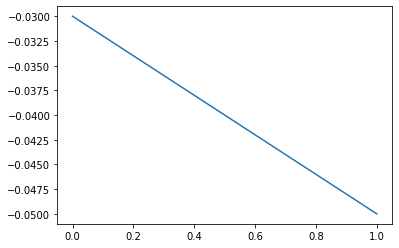

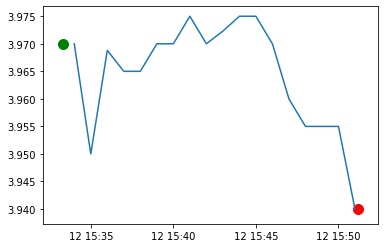

buy time:2020-02-12T15:33:17.783577706Z sell time:2020-02-12T15:51:09.269127073Z
{'rsi': 67.17044425409675, 'macd1': [0.00753582518842677, 0.007600881826012262, 0.008857540082513271, 0.010044294669999232, 0.010859623253699713], 'macd2': [0.016171609861689085, 0.016063596770281574, 0.01619762615436393, 0.016355807325158178, 0.016475180233873843], 'macd_signal': [0.009117264821037545, 0.008813988222032488, 0.008822698594128644, 0.009067017809302762, 0.009425538898182153]}
{'rsi': 37.85302939877838, 'macd': [0.0035004910510063603, 0.002527897267230017, 0.0017372021465309473, 0.0010985150116153974, -0.00019265048327454792], 'bail_out': 0, 'too_close': 1, 'macd_signal': [0.00449486887489297, 0.004101474553360379, 0.0036286200719944928, 0.0031225990599186735, 0.0024595491512800294], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0026521996345545773}


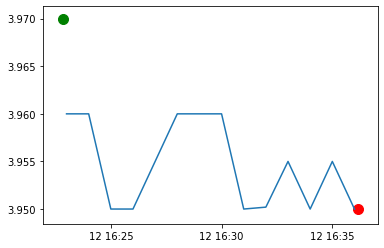

buy time:2020-02-12T16:22:49.814161025Z sell time:2020-02-12T16:36:08.310029515Z
{'rsi': 64.2824041314768, 'macd1': [0.0012328722937260395, 0.0018640544937982284, 0.0023373276762619355, 0.003080349939716065, 0.004026246585559612], 'macd2': [0.004731183922696225, 0.0047531682246222395, 0.0047657924572623855, 0.004849752948856256, 0.004999210797461462], 'macd_signal': [-0.0012760651007276951, -0.0006480411818225104, -5.096741020562117e-05, 0.000575296059778716, 0.0012654861649348953]}
{'rsi': 46.47074421055582, 'macd': [0.0005433540693955408, 0.0004838254765666683, 0.00017141585258872993, 0.00018549386179333993, -6.568553183683434e-05], 'bail_out': 0, 'too_close': 1, 'macd_signal': [0.0011317932367809883, 0.0010021996847381243, 0.0008360429183082455, 0.0007059331070052644, 0.0005516093792368446], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.000617294911073679}
AAOI analysis for run 56


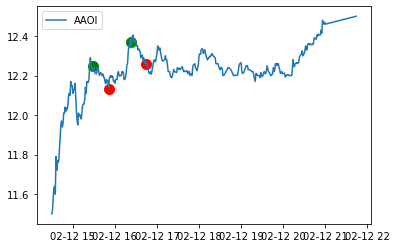

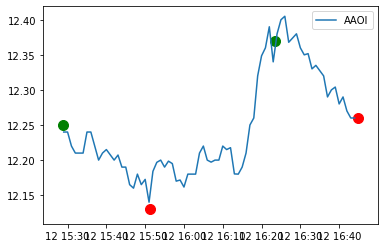

Delta = -0.22999999999999865


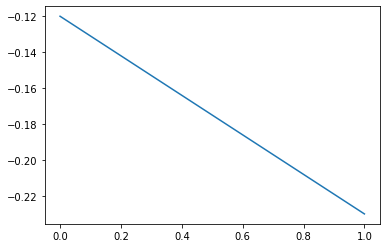

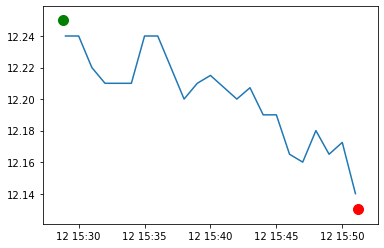

buy time:2020-02-12T15:28:48.448512144Z sell time:2020-02-12T15:51:10.046921315Z
{'rsi': 67.76437588010812, 'macd1': [0.04774222247281301, 0.0548716539640548, 0.06302295608438158, 0.06550021038282239, 0.06669463799119768], 'macd2': [0.08323152135661793, 0.08431275280690365, 0.08581241796319361, 0.08641516880396338, 0.08683150987129551], 'macd_signal': [0.039770016888917264, 0.04279034430394477, 0.04683686666003213, 0.05056953540459018, 0.05379455592191168]}
{'rsi': 41.48348491684439, 'macd': [0.0043713296050924555, 0.003289513061369931, 0.0016245974031257049, 0.0006957722486085061, -0.001969491147749025], 'bail_out': 0, 'too_close': 1, 'macd_signal': [0.013043427055798204, 0.011092644256912549, 0.00919903488615518, 0.007498382358645845, 0.005604807657366871], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.007574298805115896}


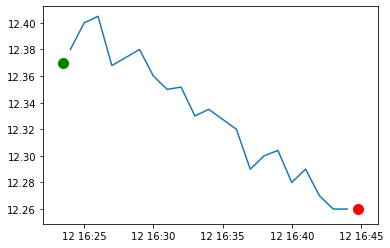

buy time:2020-02-12T16:23:26.938389028Z sell time:2020-02-12T16:44:46.362037089Z
{'rsi': 74.46023266315723, 'macd1': [0.0194722754013128, 0.027443253764714015, 0.03428498035980532, 0.04164775783049102, 0.04534625575959694], 'macd2': [0.034850745807991856, 0.036160158286028476, 0.037489353599431396, 0.03913210489960761, 0.04026103025830707], 'macd_signal': [0.009604744044164597, 0.013172445988274481, 0.017394952862580648, 0.022245513856162722, 0.026865662236849566]}
{'rsi': 41.285699395880584, 'macd': [0.004904384168943565, 0.0030170476853363937, 0.00046825240349512853, -0.00204338356162026, -0.003973965046624173], 'bail_out': 0, 'too_close': 0, 'macd_signal': [0.014395048366586574, 0.012119448230336538, 0.009789209064968257, 0.0074226905396505526, 0.005143359422395607], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.009117324469019781}
DEAC analysis for run 56


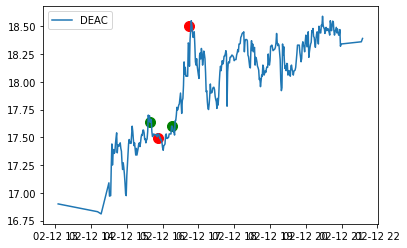

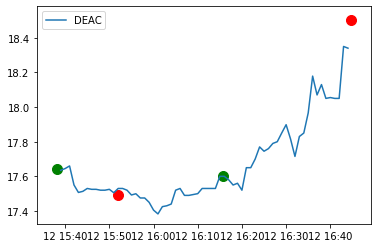

Delta = 0.7499999999999964


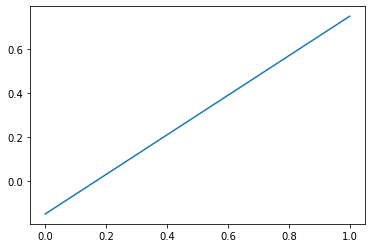

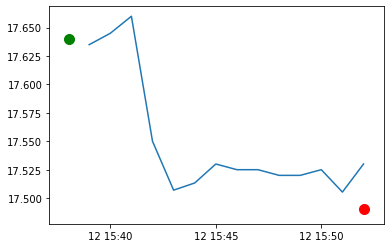

buy time:2020-02-12T15:38:02.715518038Z sell time:2020-02-12T15:52:01.355345731Z
{'rsi': 63.45327552654945, 'macd1': [0.03285171898322048, 0.03049323640171764, 0.03348310632901175, 0.04740983511729979, 0.05379220285607644], 'macd2': [0.06704699676409476, 0.06609503414489026, 0.06615307248020841, 0.06849970739409983, 0.06974945073967831], 'macd_signal': [0.040755941138030174, 0.038703400190767664, 0.03765934141841648, 0.03960944015819314, 0.0424459926977698]}
{'rsi': 45.43827506995997, 'macd': [0.007214060526795407, 0.005127486594084019, 0.003694734353089757, 0.0015069438490264986, -0.0010122038664626132], 'bail_out': 0, 'too_close': 1, 'macd_signal': [0.01790166947517497, 0.01534683289895678, 0.013016413189783376, 0.010714519321632001, 0.008369174684013079], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.009381378550475692}


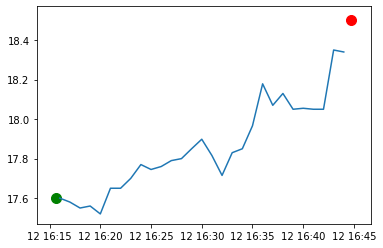

buy time:2020-02-12T16:15:40.595674081Z sell time:2020-02-12T16:44:44.815994233Z
{'rsi': 66.26724359692969, 'macd1': [-0.001062459723030429, 0.002095409914826263, 0.0045456449881911, 0.0064135426099092285, 0.013387951941908227], 'macd2': [0.027176339080416057, 0.026969803128935155, 0.02673664901583095, 0.02647937824001545, 0.02731988301086119], 'macd_signal': [-0.00926186799009885, -0.0069904124091138276, -0.004683200929652842, -0.0024638522217404276, 0.0007065086109893036]}
{'rsi': 78.03074025415155, 'macd': [0.0781875920312558, 0.07605039852448314, 0.07339738542148311, 0.08596130527081414, 0.10138823885119308], 'bail_out': 0, 'too_close': 0, 'macd_signal': [0.06692188028566384, 0.0687475839334277, 0.06967754423103878, 0.07293429643899385, 0.07862508492143369], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 1, 'distance_macd_to_signal_macd': 0.02276315392975939}
TEN analysis for run 56


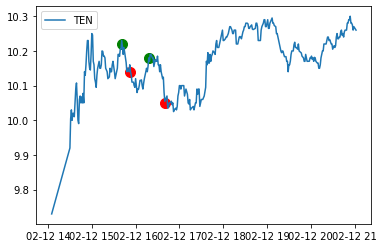

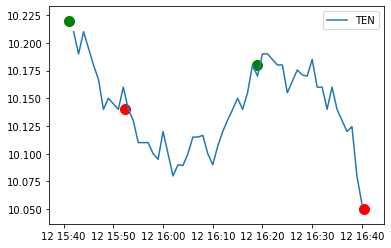

Delta = -0.20999999999999908


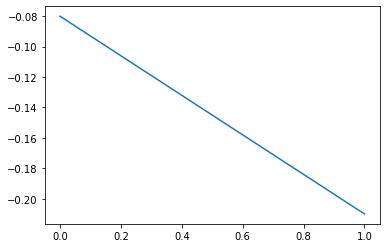

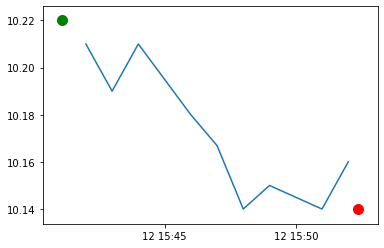

buy time:2020-02-12T15:41:06.226510715Z sell time:2020-02-12T15:52:21.52133749Z
{'rsi': 64.42219077197632, 'macd1': [0.006951774138176603, 0.008600526113641038, 0.011429599301100879, 0.013515857789268892, 0.01619294512000735], 'macd2': [0.03758177510429128, 0.03718224134834003, 0.037083058566317106, 0.03693249806423893, 0.03697481325514751], 'macd_signal': [0.00465513210786225, 0.005444210909018007, 0.006641288587434581, 0.008016202427801444, 0.009651550966242626]}
{'rsi': 42.149228592008186, 'macd': [0.00879133519231523, 0.0069053087290154025, 0.003948595787106157, 0.0021128636792919764, -0.0003839777512020248], 'bail_out': 0, 'too_close': 1, 'macd_signal': [0.007726256965248938, 0.007562067318002231, 0.006839373011823016, 0.005894071145316808, 0.004638461366013041], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.005022439117215066}


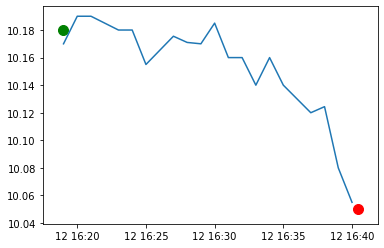

buy time:2020-02-12T16:18:56.799975696Z sell time:2020-02-12T16:40:24.311544579Z
{'rsi': 64.57811948000747, 'macd1': [-0.005207767217232373, -0.0021082408203731973, -0.0004535322094980643, 0.0020446415706398824, 0.005972901465954195], 'macd2': [0.007916198416719311, 0.008058456774719502, 0.008016514613448322, 0.008205009226987414, 0.00876514759917768], 'macd_signal': [-0.011004584291978089, -0.00922531559765711, -0.007470958920025301, -0.005567838821892265, -0.0032596907643229725]}
{'rsi': 29.61933657777666, 'macd': [0.002046267289548709, -0.00017039290681530872, -0.0016668762688283323, -0.005117812963009172, -0.009039090738177435], 'bail_out': 0, 'too_close': 1, 'macd_signal': [0.005223450062310984, 0.004144681468485725, 0.0029823699210229137, 0.0013623333442164967, -0.0007179514722622897], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.008321139265915146}
NBR analysis for run 56


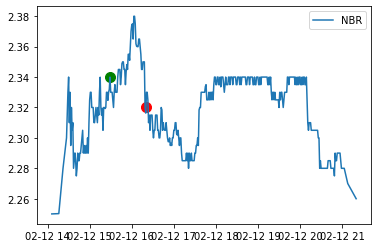

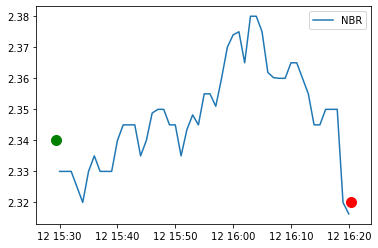

Delta = -0.020000000000000018


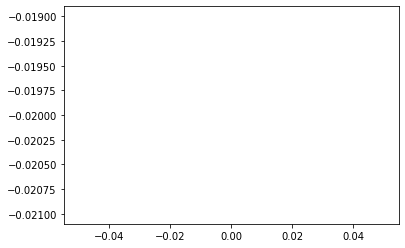

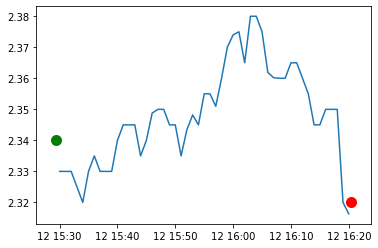

buy time:2020-02-12T15:29:26.810292113Z sell time:2020-02-12T16:20:24.446136695Z
{'rsi': 61.3847670455868, 'macd1': [0.0051906954264206995, 0.005581885551145582, 0.00540197028645828, 0.005781786300888658, 0.006651650285973698], 'macd2': [0.01257841533684445, 0.012532648891277809, 0.012385731983315829, 0.0123475077797357, 0.012420540997025942], 'macd_signal': [0.005969793715571133, 0.005892212082686023, 0.005794163723440474, 0.005791688238930111, 0.005963680648338828]}
{'rsi': 33.43091612618295, 'macd': [-0.0002865262601638996, -0.0005969802035372673, -0.0008311393775488618, -0.0025612486121353584, -0.003616382449317612], 'bail_out': 0, 'too_close': 1, 'macd_signal': [0.001939788855993353, 0.0014324350440872288, 0.0009797201597600107, 0.00027152640538093684, -0.0005060553655587731], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0031103270837588392}
EQT analysis for run 56


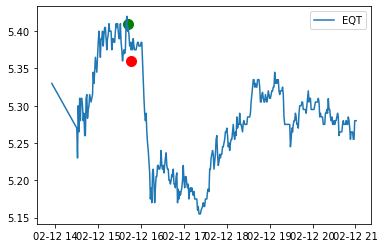

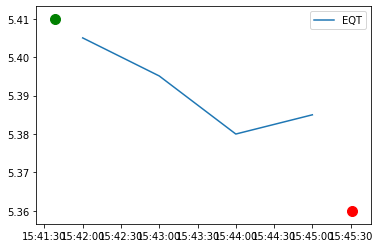

Delta = -0.04999999999999982


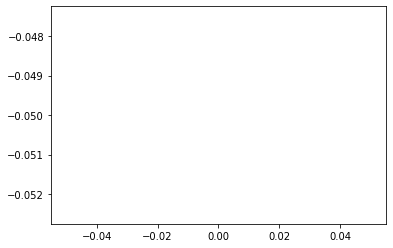

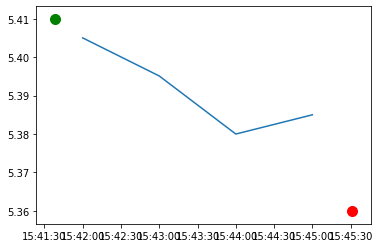

buy time:2020-02-12T15:41:38.642956431Z sell time:2020-02-12T15:45:30.872354485Z
{'rsi': 60.15185076424602, 'macd1': [0.0004808839660288555, -0.0005878606406017894, -0.0010196364931980284, 0.0014457201635220684, 0.003759652357095078], 'macd2': [0.02097898977782897, 0.020274904995802423, 0.019674665610186715, 0.019650735386779417, 0.019677258223401495], 'macd_signal': [0.005855243615839425, 0.004566622764551182, 0.0034493709130013397, 0.0030486407631054855, 0.003190843081903404]}
{'rsi': 42.05167206923217, 'macd': [0.002148564818577725, 0.002664928120814203, 0.0025183939651443055, 0.0015870895066329993, -0.00019817487021533964], 'bail_out': 0, 'too_close': 1, 'macd_signal': [0.0011708119421112158, 0.001469635177851813, 0.0016793869353103116, 0.0016609274495748491, 0.0012891069856168114], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.001487281855832151}
SPWR analysis for run 56


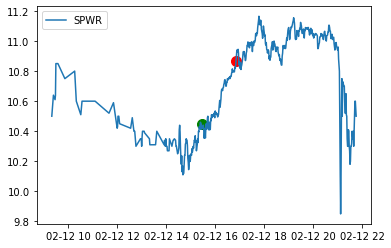

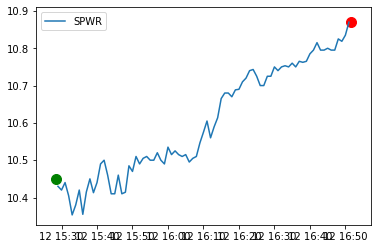

Delta = 0.41999999999999993


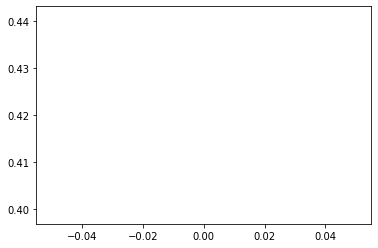

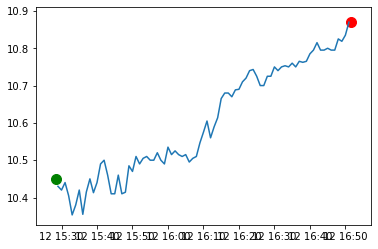

buy time:2020-02-12T15:28:34.298155134Z sell time:2020-02-12T16:51:37.347632628Z
{'rsi': 66.75976762184179, 'macd1': [0.046077949426367226, 0.04968077710239882, 0.04818805488729794, 0.04914973343800533, 0.053818288046814544], 'macd2': [0.0568399532649444, 0.057790041673200676, 0.05782002698335731, 0.05829252442067734, 0.05953124753366801], 'macd_signal': [0.038424427136606445, 0.04067569712976492, 0.04217816868127152, 0.04357248163261828, 0.04562164291545753]}
{'rsi': 78.63133017883148, 'macd': [0.019518459353754736, 0.019995385629137274, 0.019774868627758124, 0.020198168774376413, 0.022359205657787484], 'bail_out': 0, 'too_close': 0, 'macd_signal': [0.022032154044203903, 0.021624800361190577, 0.021254814014504086, 0.02104348496647855, 0.02130662910474034], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0010525765530471458}
HBM analysis for run 56


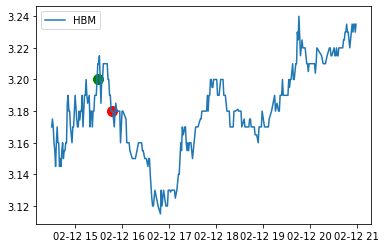

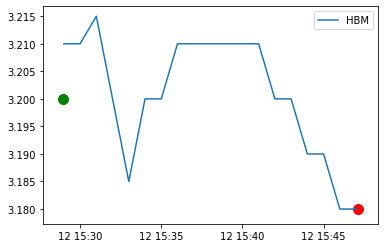

Delta = -0.020000000000000018


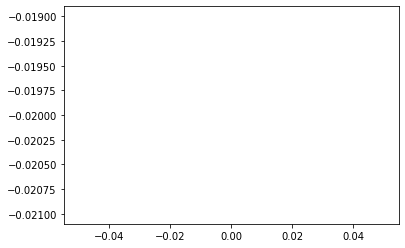

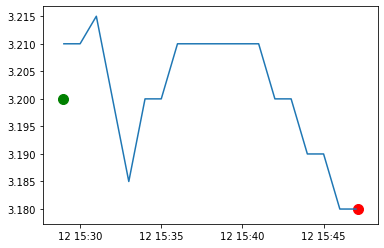

buy time:2020-02-12T15:28:56.214160774Z sell time:2020-02-12T15:47:05.388257208Z
{'rsi': 60.38487615857089, 'macd1': [0.00377755682963965, 0.003473792447641788, 0.00399393382986446, 0.0043559370913794915, 0.005387638369302561], 'macd2': [0.012453175447324938, 0.012235678468312639, 0.012175941058244266, 0.012101507013941859, 0.012173606668481884], 'macd_signal': [0.006450440482266366, 0.0058551108753414505, 0.005482875466246052, 0.00525748779127274, 0.005283517906878704]}
{'rsi': 43.834200742924736, 'macd': [0.003389999884443551, 0.002395410779795437, 0.0015892970517610294, 0.0004210357435292522, -0.000235025480333384], 'bail_out': 0, 'too_close': 1, 'macd_signal': [0.004146375580945102, 0.003796182620715169, 0.003354805506924341, 0.002768051554245323, 0.0021674361473295817], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0024024616276629657}
GSS analysis for run 56


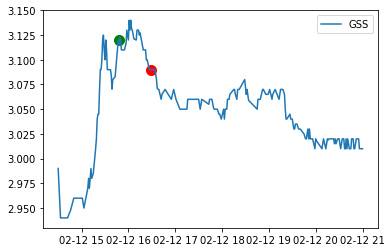

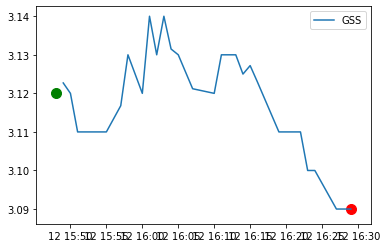

Delta = -0.03000000000000025


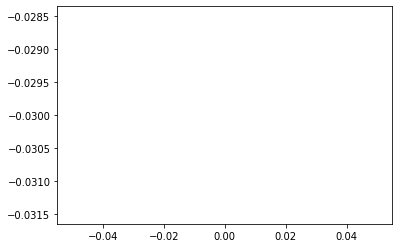

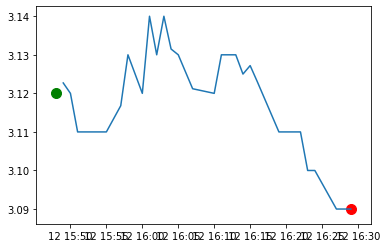

buy time:2020-02-12T15:48:02.811894159Z sell time:2020-02-12T16:29:02.672765936Z
{'rsi': 68.26615484366769, 'macd1': [0.02226807326842639, 0.020256352279198087, 0.018680715010951143, 0.0201928998861316, 0.02114754159875254], 'macd2': [0.01912306733686986, 0.01909927078899365, 0.019093212036566776, 0.0196504635209811, 0.020131724541194274], 'macd_signal': [0.028840174238610634, 0.027123409846728126, 0.02543487087957273, 0.024386476680884502, 0.02373868966445811]}
{'rsi': 36.36137830361808, 'macd': [0.0010623361936614728, 1.5445634550914633e-05, -0.0008005138353346375, -0.001945410645176171, -0.0028122729561541604], 'bail_out': 0, 'too_close': 1, 'macd_signal': [0.00393850905745894, 0.003153896372877335, 0.0023630143312349406, 0.0015013293359527184, 0.0006386088775313427], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.003450881833685503}
BGG analysis for run 56


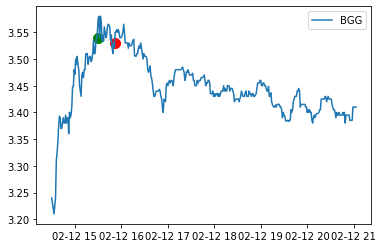

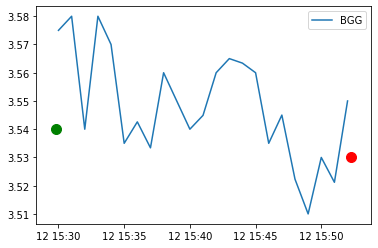

Delta = -0.010000000000000231


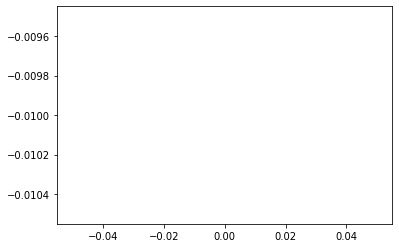

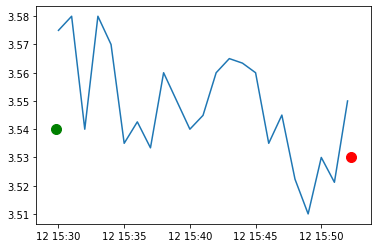

buy time:2020-02-12T15:29:50.547189613Z sell time:2020-02-12T15:52:16.502404441Z
{'rsi': 66.97475195101549, 'macd1': [0.023967156001022616, 0.022755788687653045, 0.02312687368501143, 0.023951776475705344, 0.024723973517124076], 'macd2': [0.03920572521202503, 0.038891526088925765, 0.03885692461487267, 0.03892287995663368, 0.03900127728632796], 'macd_signal': [0.026379905485596968, 0.025655082126008182, 0.025149440437808833, 0.024909907645388134, 0.024872720819735322]}
{'rsi': 49.31364786394373, 'macd': [0.003916820605875948, 0.0017163477337338584, 0.0010183643563017597, 4.112836792025121e-06, -0.0003291235788878133], 'bail_out': 0, 'too_close': 0, 'macd_signal': [0.007645029707364512, 0.006459293312638381, 0.0053711075213710565, 0.004297708584455251, 0.003372342151786638], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.003701465730674451}
SMLP analysis for run 56


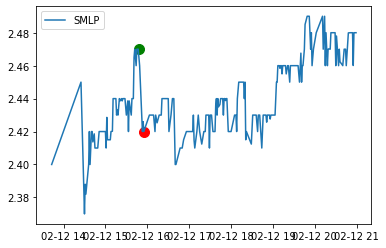

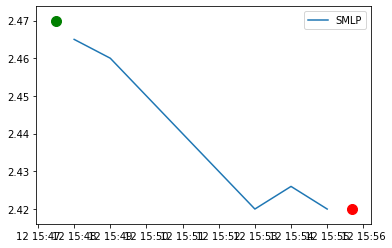

Delta = -0.050000000000000266


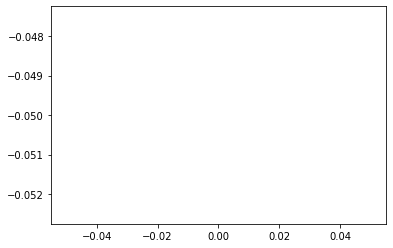

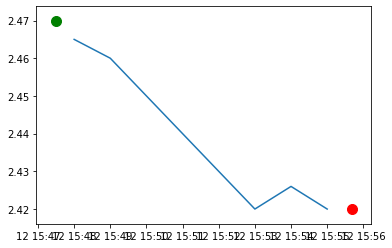

buy time:2020-02-12T15:47:29.587525525Z sell time:2020-02-12T15:55:40.378548787Z
{'rsi': 65.30066558398006, 'macd1': [0.008877294254516332, 0.009816212262136137, 0.010041105718110455, 0.010900596537256835, 0.011449763457815898], 'macd2': [0.011384491957145304, 0.01161612105903398, 0.011730680866794518, 0.011977253995218984, 0.01218495321654034], 'macd_signal': [0.006859784949106516, 0.007451070411712441, 0.007969077472992043, 0.008555381285845001, 0.00913425772023918]}
{'rsi': 40.06481809646304, 'macd': [0.006267853285505609, 0.004314332269595766, 0.0022165972926577737, 0.0008648999431910553, -0.0005112914972138505], 'bail_out': 0, 'too_close': 1, 'macd_signal': [0.005647729075536576, 0.005381049714348414, 0.004748159230010286, 0.00397150737264644, 0.0030749475986743815], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.003586239095888232}
EGLE analysis for run 56


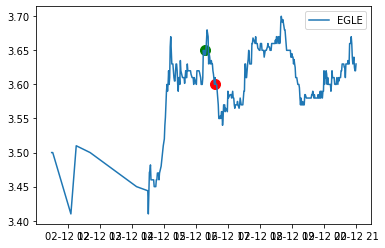

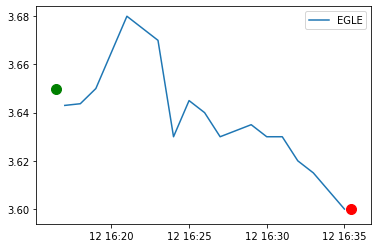

Delta = -0.04999999999999982


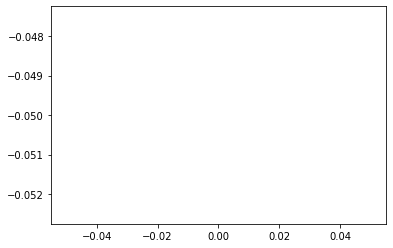

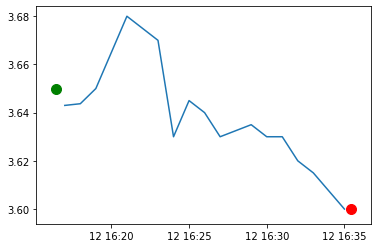

buy time:2020-02-12T16:16:27.112953771Z sell time:2020-02-12T16:35:26.319950297Z
{'rsi': 66.68816705201645, 'macd1': [-0.0006816722637084105, -0.0004984302711741329, 0.002841698700426054, 0.005147022553384506, 0.007173734716774849], 'macd2': [0.0170506703802924, 0.016610070217871087, 0.016817882591080302, 0.016926201159809473, 0.017054764223386254], 'macd_signal': [0.001406189274559932, 0.001025265365413119, 0.0013885520324157061, 0.002140246136609466, 0.0031469438526425426]}
{'rsi': 38.820896296826916, 'macd': [0.0033977032366570015, 0.0026777918079377017, 0.0015625648270143344, 0.0004135234804896193, -0.0012664246269387114], 'bail_out': 0, 'too_close': 1, 'macd_signal': [0.005041062074680995, 0.0045684080213323364, 0.003967239382468736, 0.003256496202072913, 0.002351912036270588], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0036183366632092993}
AMX analysis for run 56


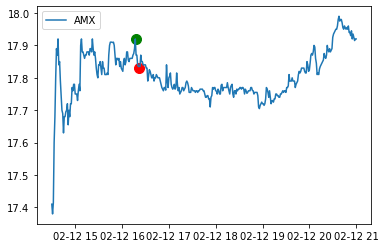

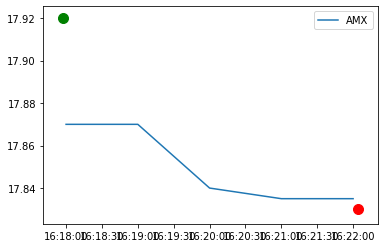

Delta = -0.09000000000000341


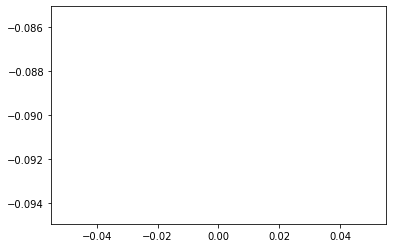

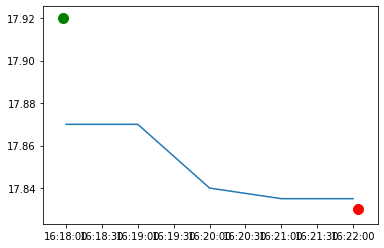

buy time:2020-02-12T16:17:57.341889036Z sell time:2020-02-12T16:22:03.822141271Z
{'rsi': 67.14992065707438, 'macd1': [0.0017473963171923401, 0.0025950817564570627, 0.003628509587716877, 0.005593405927449169, 0.0094622745021411], 'macd2': [0.02954323227027089, 0.028921290220349505, 0.028382796090902218, 0.028081873989254547, 0.028239911073683288], 'macd_signal': [0.0010874363252584831, 0.001388965411498199, 0.0018368742467419347, 0.0025881805828833816, 0.0039629993667349254]}
{'rsi': 42.9390049588304, 'macd': [0.00515538337336352, 0.004534478084224247, 0.0024333248967884913, 0.0005047207910351403, -0.001004642418525492], 'bail_out': 0, 'too_close': 1, 'macd_signal': [0.00279372272843617, 0.0031418737995937856, 0.003000164019032727, 0.0025010753734332094, 0.001799931815041469], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.002804574233566961}
SWCH analysis for run 56


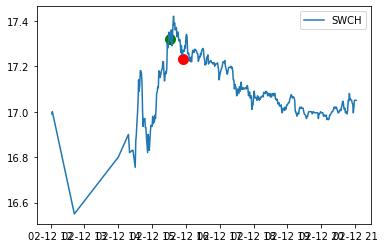

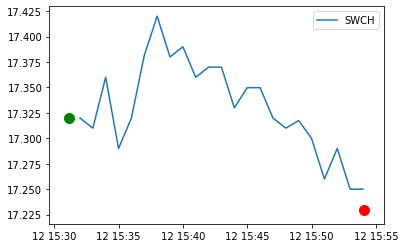

Delta = -0.08999999999999986


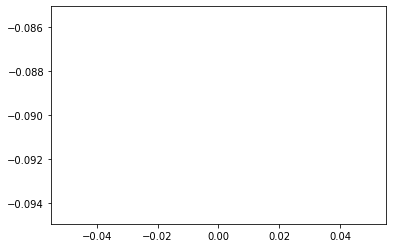

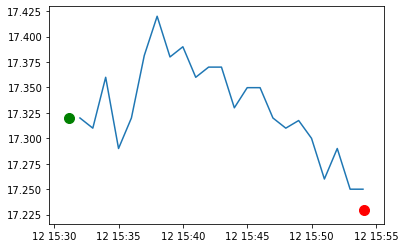

buy time:2020-02-12T15:31:09.862269724Z sell time:2020-02-12T15:54:04.74378204Z
{'rsi': 74.59595960633767, 'macd1': [0.053753106001266815, 0.052214815887570154, 0.05759404937811752, 0.06354536850173176, 0.06935856304585641], 'macd2': [0.07843025615269283, 0.07814399511424952, 0.07919506963247613, 0.08051523844011399, 0.08197691275943342], 'macd_signal': [0.06262874190401362, 0.06054595670072492, 0.05995557523620344, 0.06067353388930911, 0.062410539720618566]}
{'rsi': 41.55088383827172, 'macd': [0.014057607851093223, 0.00919235860003198, 0.006840315565437294, 0.002840797414254581, -0.0013515647478890003], 'bail_out': 0, 'too_close': 1, 'macd_signal': [0.0251442736923485, 0.021953890673885194, 0.018931175652195615, 0.01571310000460741, 0.012300167054108127], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.013651731801997127}
ARAY analysis for run 56


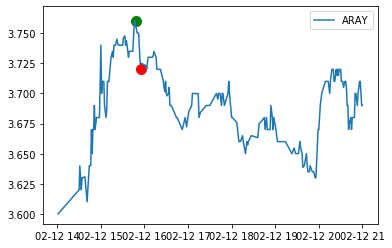

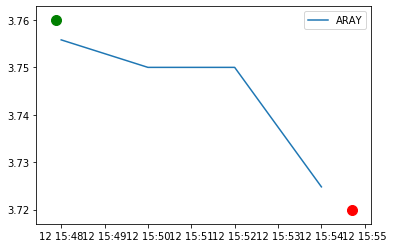

Delta = -0.03999999999999959


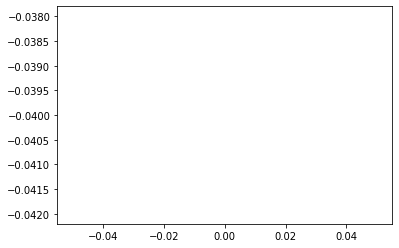

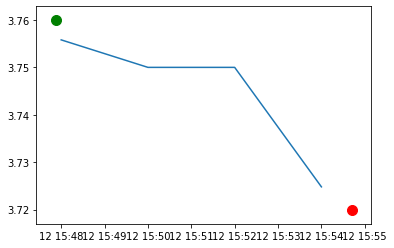

buy time:2020-02-12T15:47:52.734625563Z sell time:2020-02-12T15:54:41.771519232Z
{'rsi': 68.50730178669502, 'macd1': [0.012325923349674195, 0.011295526887836527, 0.010359512259469739, 0.011502412339701618, 0.012266765253390766], 'macd2': [0.018945530045201053, 0.018746767835190248, 0.01853391740873045, 0.01870828586098172, 0.018838789125750655], 'macd_signal': [0.016445718704267913, 0.015415680340981636, 0.014404446724679257, 0.013824039847683729, 0.013512584928825136]}
{'rsi': 39.502949013105464, 'macd': [0.006592474267661963, 0.006701394943803951, 0.006397938393475577, 0.00607838863486343, 0.0036725266328940798], 'bail_out': 0, 'too_close': 1, 'macd_signal': [0.007321267237744093, 0.007197292778956065, 0.007037421901859967, 0.006845615248460659, 0.006210997525347343], 'data.close <= stop_prices': 1, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0025384708924532633}
DDD analysis for run 56


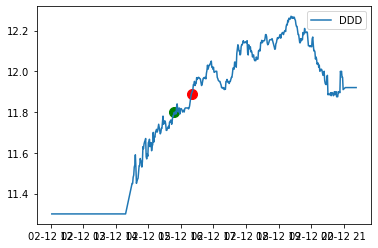

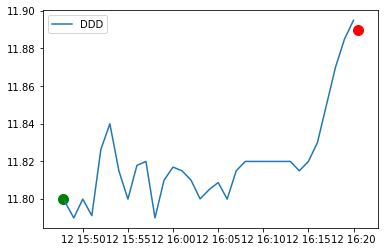

Delta = 0.08999999999999986


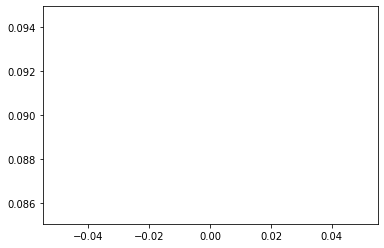

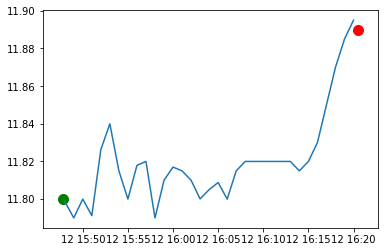

buy time:2020-02-12T15:47:47.012537923Z sell time:2020-02-12T16:20:26.802030673Z
{'rsi': 68.30468463546005, 'macd1': [0.01713762970542909, 0.017313487037965203, 0.019016925266726048, 0.02013481077055168, 0.022376632053941137], 'macd2': [0.04460029464888393, 0.04412274957164719, 0.04396628326976604, 0.04375201134105389, 0.04380477113580383], 'macd_signal': [0.018948449950723346, 0.018621457368171716, 0.01870055094788258, 0.0189874029124164, 0.01966524874072135]}
{'rsi': 78.04747524469734, 'macd': [0.005701448781117335, 0.0068737984214148895, 0.008737008551237935, 0.010854613736148266, 0.012883207208336245], 'bail_out': 0, 'too_close': 0, 'macd_signal': [0.006475126794239003, 0.006554861119674181, 0.0069912906059869315, 0.0077639552320191985, 0.008787805627282607], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.004095401581053638}
LX analysis for run 56


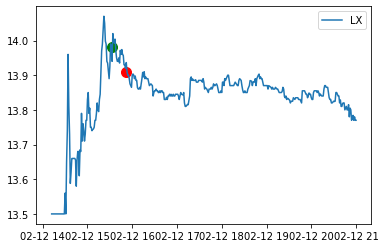

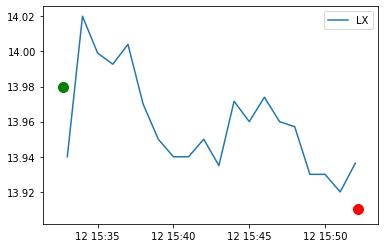

Delta = -0.07000000000000028


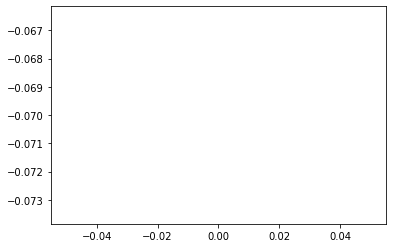

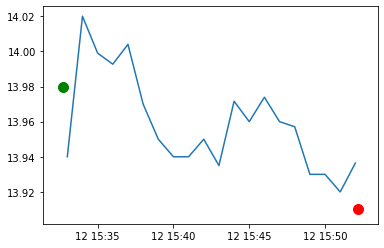

buy time:2020-02-12T15:32:42.041965806Z sell time:2020-02-12T15:52:08.52690188Z
{'rsi': 62.38297224644577, 'macd1': [0.06589606246338064, 0.05638093118305321, 0.051075561306067385, 0.051522059991549796, 0.05208245571389014], 'macd2': [0.07175504588810533, 0.07045497900279862, 0.06970596907912707, 0.06994495520040367, 0.07021289892061944], 'macd_signal': [0.0679344041739012, 0.0656237095757316, 0.06271407992179875, 0.060475675935748964, 0.0587970318913772]}
{'rsi': 44.483877332325726, 'macd': [0.006991930505540367, 0.0047962812569792845, 0.0030230963716455506, 0.001082652352273783, -0.0009629228881760099], 'bail_out': 0, 'too_close': 1, 'macd_signal': [0.011263512840929583, 0.009970066524139523, 0.008580672493640728, 0.0070810684653673395, 0.00547227019465867], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.00643519308283468}
RRD analysis for run 56


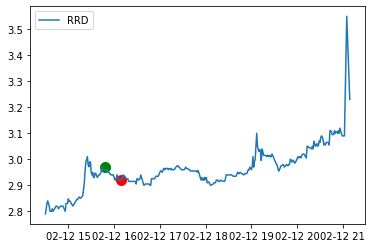

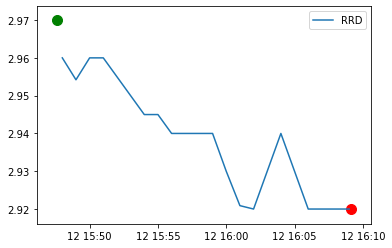

Delta = -0.050000000000000266


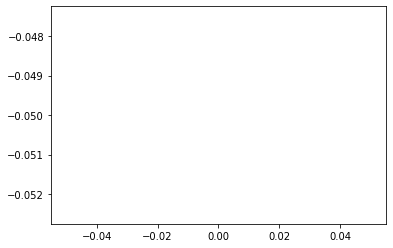

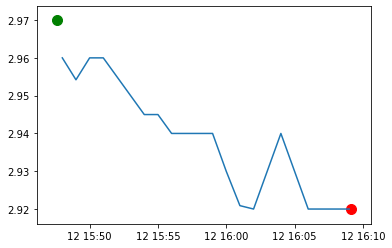

buy time:2020-02-12T15:47:34.531141594Z sell time:2020-02-12T16:09:09.12167676Z
{'rsi': 64.67644993639965, 'macd1': [0.024081020539611142, 0.02237615769394541, 0.021583160789860667, 0.022311346568257395, 0.022866918371066358], 'macd2': [0.025466842190768446, 0.025415981108069197, 0.02548847400062293, 0.025834276579496773, 0.026159088505794514], 'macd_signal': [0.030954828912818762, 0.02923909466904409, 0.027707907893207408, 0.026628595628217407, 0.025876260176787198]}
{'rsi': 42.8971988230642, 'macd': [-0.0010721096896886273, -0.0008130590525703418, -0.001120122724262984, -0.0018643265889033422, -0.002420013670585419], 'bail_out': 0, 'too_close': 0, 'macd_signal': [0.002484122415099755, 0.0018246861215657356, 0.0012357243523999917, 0.0006157141641393248, 8.568597194376013e-06], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.002428582267779795}
UNIT analysis for run 56


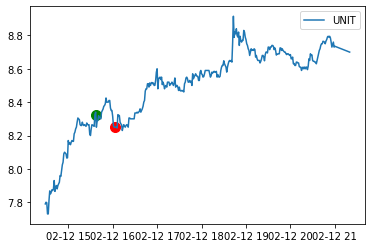

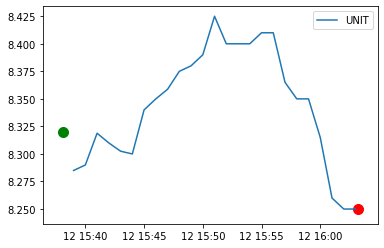

Delta = -0.07000000000000028


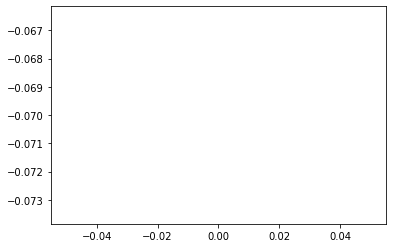

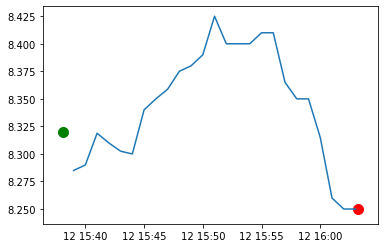

buy time:2020-02-12T15:38:04.166639278Z sell time:2020-02-12T16:03:10.363834515Z
{'rsi': 68.45972442838428, 'macd1': [0.02190943727062944, 0.021107436952620517, 0.019839688134206668, 0.024204389907422907, 0.0273481945456151], 'macd2': [0.06056735934316926, 0.059773722881029556, 0.05886798422012873, 0.0590600767448759, 0.059142349672690386], 'macd_signal': [0.032391205754740485, 0.03013445199431649, 0.028075499222294527, 0.027301277359320204, 0.027310660796579185]}
{'rsi': 34.215565719258976, 'macd': [0.014577391902697912, 0.010379105618424589, 0.004115777271998411, -0.0013376704949834561, -0.005569737969318922], 'bail_out': 0, 'too_close': 1, 'macd_signal': [0.019709967823071817, 0.017843795382142372, 0.01509819176011358, 0.011811019309094173, 0.008334867853411554], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.013904605822730476}
NOVA analysis for run 56


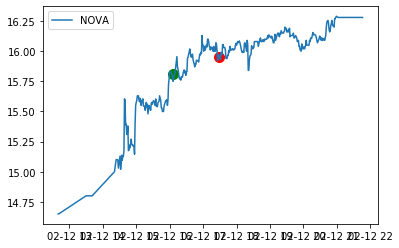

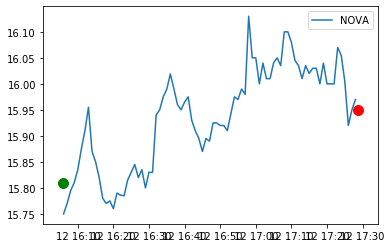

Delta = 0.1399999999999988


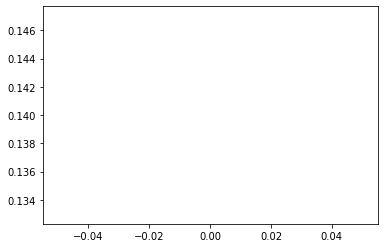

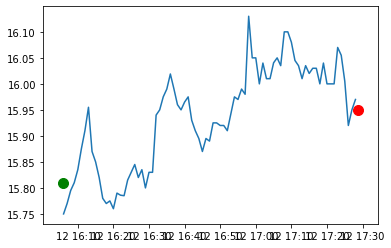

buy time:2020-02-12T16:05:49.870487262Z sell time:2020-02-12T17:28:36.810487014Z
{'rsi': 71.73585527529708, 'macd1': [0.04815978791632425, 0.05876207029077207, 0.06639904855803813, 0.07082803097759793, 0.07269315360286477], 'macd2': [0.05810292921774263, 0.060348510300066494, 0.062317997716789364, 0.06387038418420765, 0.06503654161115335], 'macd_signal': [0.0214852707917711, 0.028940630691571295, 0.036432314264864665, 0.04331145760741132, 0.04918779680650201]}
{'rsi': 42.902964460208494, 'macd': [0.004972205365710636, 0.0031867736127608737, -0.0026614429948992324, -0.005625489143788798, -0.007862077193005135], 'bail_out': 0, 'too_close': 1, 'macd_signal': [0.006379420455370301, 0.005740891086848415, 0.004060424270498885, 0.0021232415876413484, 0.0001261778315120518], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.007988255024517187}
CAN analysis for run 56


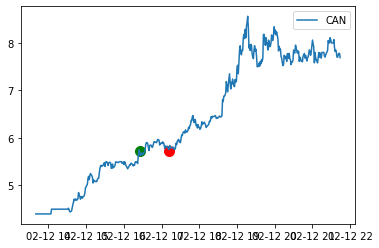

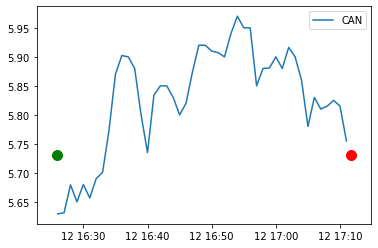

Delta = 0.0


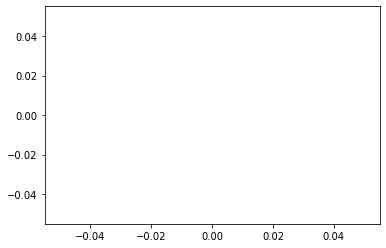

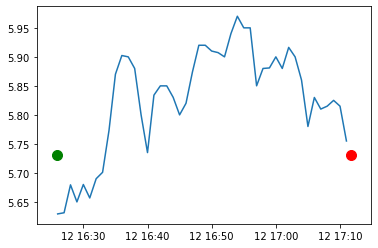

buy time:2020-02-12T16:25:49.449581456Z sell time:2020-02-12T17:11:45.586246562Z
{'rsi': 74.62602395870229, 'macd1': [0.01289758358394355, 0.011910374265833745, 0.024562442472262802, 0.04376776722120557, 0.05746233484819818], 'macd2': [0.05742708756536086, 0.05610743559204412, 0.057522489997094084, 0.06065161843613076, 0.0632623813567541], 'macd_signal': [0.006573964242356763, 0.007641246247052159, 0.011025485492094287, 0.017573941837916544, 0.025551620439972875]}
{'rsi': 37.72172820024569, 'macd': [0.0014882890820286931, -0.0009971833261763763, -0.0024014841205417525, -0.00398403689380622, -0.009565454160066267], 'bail_out': 0, 'too_close': 1, 'macd_signal': [0.014577517313159089, 0.011462577185291995, 0.008689764924125246, 0.0061550045605389524, 0.0030109128164179082], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.012576366976484175}
PVAC analysis for run 56


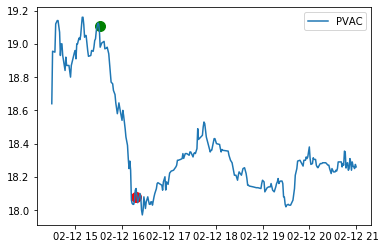

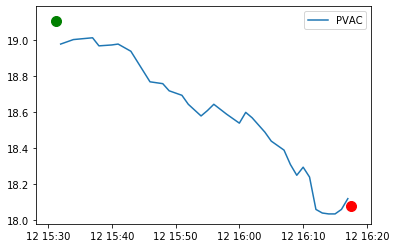

Delta = -1.0300000000000011


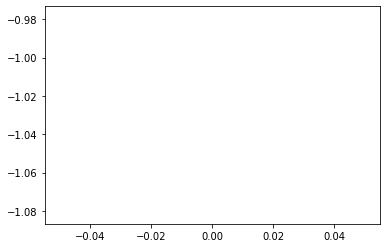

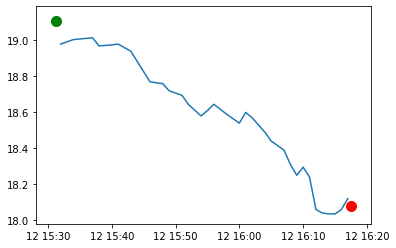

buy time:2020-02-12T15:31:19.795953923Z sell time:2020-02-12T16:17:31.374570174Z
{'rsi': 65.02608271119105, 'macd1': [0.02933515367513806, 0.029710645188433915, 0.030463971642571863, 0.034528099529516965, 0.0410760276514317], 'macd2': [0.0967632255107631, 0.09567946870638977, 0.09468928786604991, 0.0943929410987252, 0.09472262295557599], 'macd_signal': [0.05472268707799752, 0.049720278700084795, 0.04586901728858221, 0.043600833736769165, 0.04309587251970167]}
{'rsi': 19.60669151087451, 'macd': [-0.10891931151636314, -0.11669140267067846, -0.12149184509389954, -0.12365463340947969, -0.12243531737733804], 'bail_out': 0, 'too_close': 0, 'macd_signal': [-0.08882777390270685, -0.09440049965630118, -0.09981876874382085, -0.10458594167695262, -0.10815581681702971], 'data.close <= stop_prices': 1, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.014279500560308328}
SALT analysis for run 56


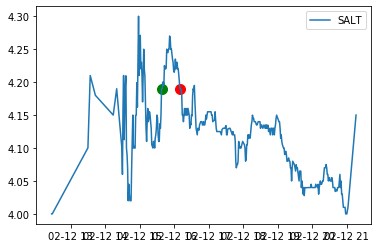

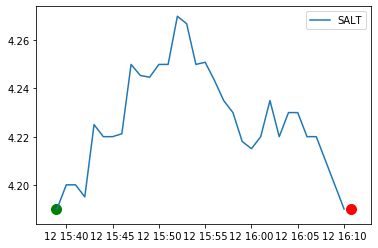

Delta = 0.0


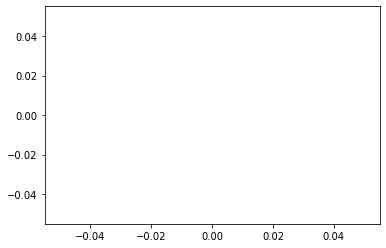

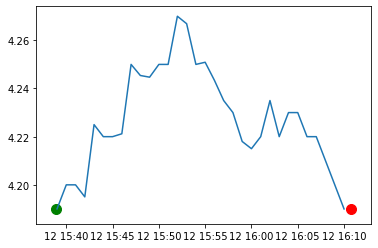

buy time:2020-02-12T15:38:55.851913297Z sell time:2020-02-12T16:10:46.62176437Z
{'rsi': 60.73571554734558, 'macd1': [-0.008005821983098294, -0.0063857812852221585, -0.00557821912836598, -0.003286502690619919, 0.0017373378539460305], 'macd2': [0.025607186375740554, 0.024962198992133366, 0.024221709281758486, 0.023821567874041882, 0.02405506981300576], 'macd_signal': [-0.007126090091528823, -0.006978028330267489, -0.006698066489887187, -0.0060157537300337335, -0.004465135413237781]}
{'rsi': 39.40862402753153, 'macd': [0.0045812567739638155, 0.003673512748849639, 0.0029184717844898955, 0.0012532649059693313, -0.0005800555825654641], 'bail_out': 0, 'too_close': 1, 'macd_signal': [0.007969982111523291, 0.00711068823898856, 0.006272244948088828, 0.0052684489396649286, 0.00409874803521885], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.004678803617784314}
NLS analysis for run 56


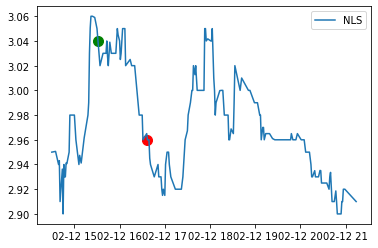

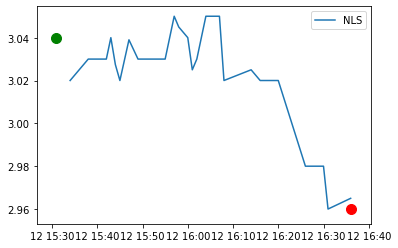

Delta = -0.08000000000000007


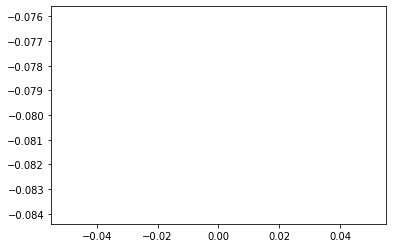

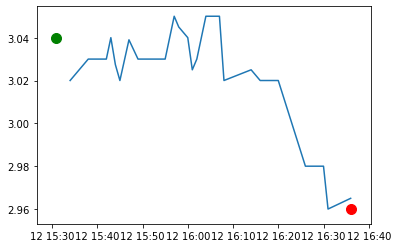

buy time:2020-02-12T15:30:57.874021446Z sell time:2020-02-12T16:36:07.832713939Z
{'rsi': 69.24245541024031, 'macd1': [0.02381113319032435, 0.027179932347190405, 0.02950956208721678, 0.0309187071873831, 0.03095243959136118], 'macd2': [0.0008458959933115295, 0.002357225988106837, 0.0037439278729816117, 0.0049977564717837986, 0.005999383253053825], 'macd_signal': [0.012602220528474012, 0.01551776289221729, 0.018316122731217188, 0.02083663962245037, 0.02285979961623253]}
{'rsi': 30.009508504261333, 'macd': [0.0025296053664738416, 0.0016091643395190758, -0.0012068827508291413, -0.0033855313569337575, -0.006078172720691999], 'bail_out': 0, 'too_close': 1, 'macd_signal': [0.00541121079044622, 0.0046508015002607915, 0.003479264650042805, 0.002106305448647492, 0.0004694098147795939], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.006547582535471593}
MHH analysis for run 56


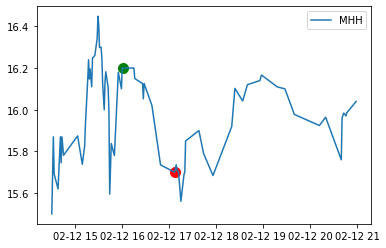

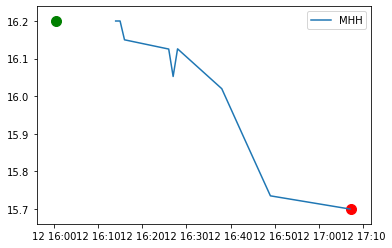

Delta = -0.5


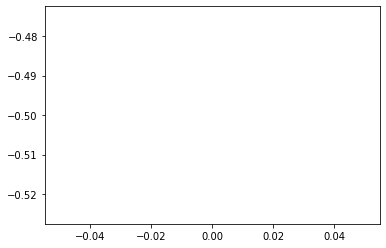

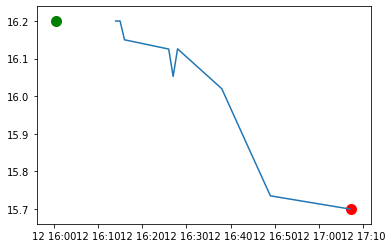

buy time:2020-02-12T16:00:25.521501229Z sell time:2020-02-12T17:07:17.295297251Z
{'rsi': 55.0807978508818, 'macd1': [0.011417547293341102, -0.008724118413221404, 0.007503626328510649, 0.013782302393078538, 0.026489728912121535], 'macd2': [0.12429377676051168, 0.11790669368146922, 0.11823923868762698, 0.11708299282773815, 0.11742491458107196], 'macd_signal': [0.09202911827554247, 0.07187847093778969, 0.059003502015933885, 0.04995926209136282, 0.045265355455514564]}
{'rsi': 38.47172960394832, 'macd': [0.01606349932116302, 0.01035882601938809, -0.000974150917311789, -0.01783914397296016, -0.03257239643225773], 'bail_out': 0, 'too_close': 1, 'macd_signal': [0.0183709544001067, 0.016768528723962978, 0.013219992795708024, 0.007008165441974387, -0.0009079469328720372], 'data.close <= stop_prices': 1, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0316644494993857}
MCF analysis for run 56


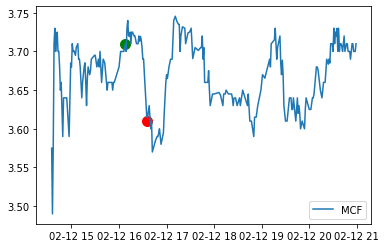

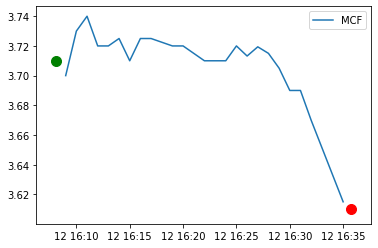

Delta = -0.10000000000000009


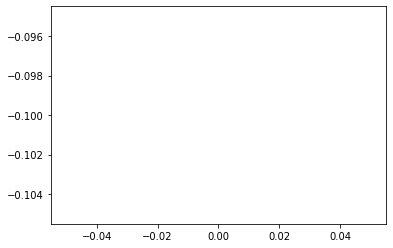

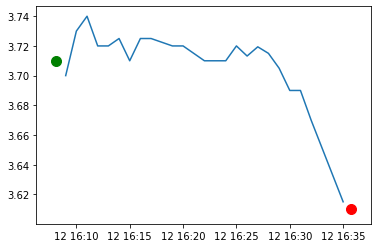

buy time:2020-02-12T16:08:06.755110443Z sell time:2020-02-12T16:35:45.560099026Z
{'rsi': 59.441399757222136, 'macd1': [-0.0012088698419558952, -3.330259664124924e-05, 0.0024835469841226754, 0.004427135151568784, 0.006697158528894853], 'macd2': [0.02259523179369438, 0.022222120119905764, 0.022163176320678435, 0.02207349923659052, 0.02211562599891259], 'macd_signal': [0.0032228408435241666, 0.0025716121554910836, 0.002553999121217402, 0.0029286263272876784, 0.0036823327676091134]}
{'rsi': 23.746510692299864, 'macd': [0.003369363895537436, 0.0018610291410854352, 0.0006615341487714588, -0.0013206896653534805, -0.006484491472913856], 'bail_out': 0, 'too_close': 1, 'macd_signal': [0.005103157014361049, 0.004454731439705926, 0.0036960919815190326, 0.00269273565214453, 0.0008572902271328526], 'data.close <= stop_prices': 1, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0073417817000467085}
BLCM analysis for run 56


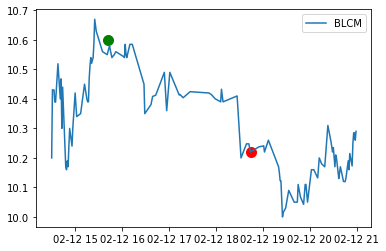

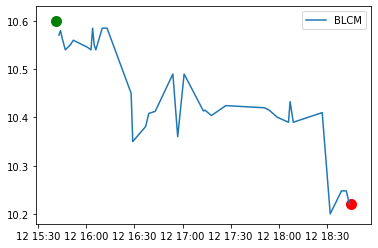

Delta = -0.379999999999999


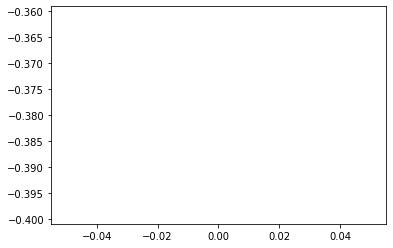

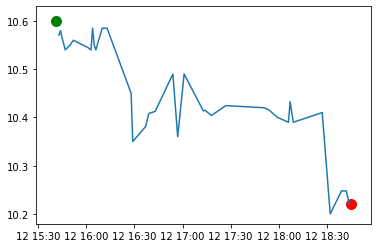

buy time:2020-02-12T15:41:28.648035894Z sell time:2020-02-12T18:45:01.553419998Z
{'rsi': 64.75822644104736, 'macd1': [0.06317668446384417, 0.06694829284423065, 0.07312891715542591, 0.08351967503849345, 0.08751790785242441], 'macd2': [-0.0018555017529013895, 0.0013314306427059108, 0.005061061078420082, 0.009763834124507653, 0.013435175764872298], 'macd_signal': [0.04535006323519265, 0.04966970915700025, 0.05436155075668538, 0.060193175613047, 0.06565812206092247]}
{'rsi': 35.44620933129429, 'macd': [-0.013865489194822445, -0.023973433976710368, -0.02906048920965354, -0.032647019401430555, -0.03645669202617441], 'bail_out': 0, 'too_close': 1, 'macd_signal': [-0.013793739164488356, -0.01582967812693276, -0.018475840343476914, -0.021310076155067643, -0.024339399329288997], 'data.close <= stop_prices': 1, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.012117292696885412}
PT analysis for run 56


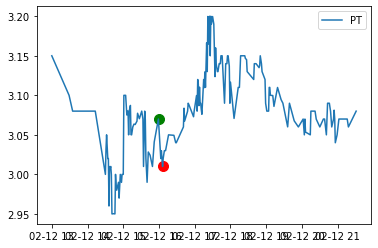

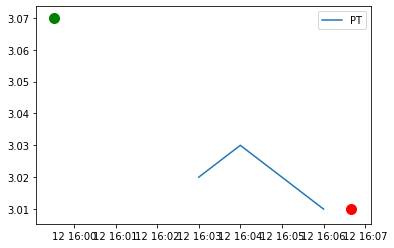

Delta = -0.06000000000000005


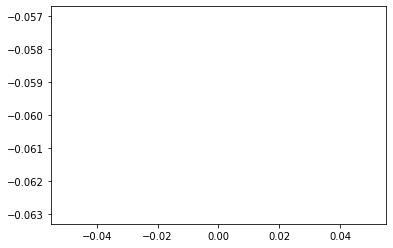

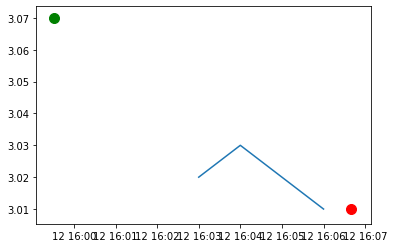

buy time:2020-02-12T15:59:30.720363233Z sell time:2020-02-12T16:06:40.236581575Z
{'rsi': 54.762576292896135, 'macd1': [0.0018156767977366428, 0.00021135170149078064, -0.002188747467379848, -0.0015633123721374709, 0.0012499295101422447], 'macd2': [0.01501180133692781, 0.014423926591514036, 0.01363128544974579, 0.013377629948343461, 0.013585078237619452], 'macd_signal': [0.011081495424156592, 0.00890746667962343, 0.006688223850222774, 0.0050379166057507255, 0.004280319186629029]}
{'rsi': 44.28638569168808, 'macd': [-0.0021748318152123858, -0.000264338950477061, -0.0013696128357416626, -0.00169359751470477, -0.0034824998942255547], 'bail_out': 0, 'too_close': 1, 'macd_signal': [0.0019542530488643444, 0.0015105346489960633, 0.0009345051520485181, 0.0004088846186978604, -0.00036939228388682265], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.003113107610338732}
QRTEA analysis for run 56


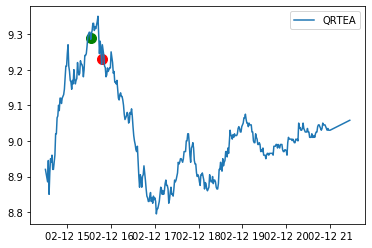

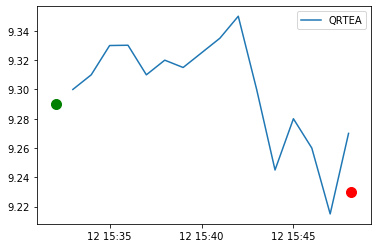

Delta = -0.05999999999999872


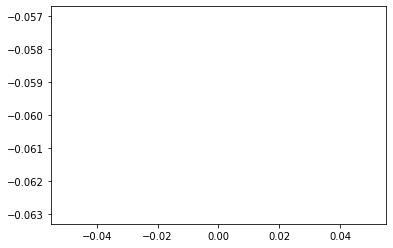

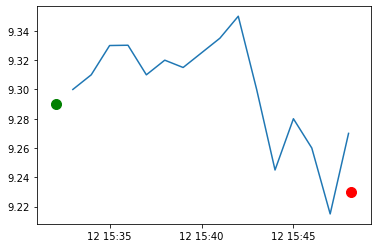

buy time:2020-02-12T15:32:06.062113521Z sell time:2020-02-12T15:48:08.89861073Z
{'rsi': 70.43159265580425, 'macd1': [0.032777284460978606, 0.035726499623894625, 0.038028859086304934, 0.039399324658434765, 0.040422916492342864], 'macd2': [0.053394810848528707, 0.05385520618172279, 0.05427261875147593, 0.05456985019809579, 0.05483600379980835], 'macd_signal': [0.029623973764701265, 0.030844478936539937, 0.03228135496649294, 0.03370494890488131, 0.03504854242237362]}
{'rsi': 41.35189740117545, 'macd': [0.01313550134224073, 0.01081816955939452, 0.007832999734327828, 0.0030675037701932695, -0.0004259671599147197], 'bail_out': 0, 'too_close': 1, 'macd_signal': [0.019054471461024857, 0.01740721108069879, 0.015492368811424597, 0.01300739580317833, 0.010320723210559721], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.01074669037047444}
CLNE analysis for run 56


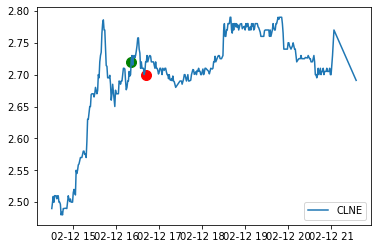

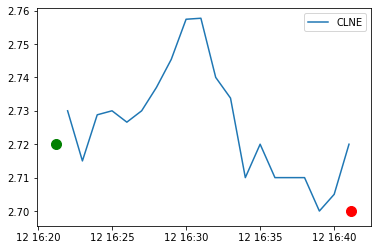

Delta = -0.020000000000000018


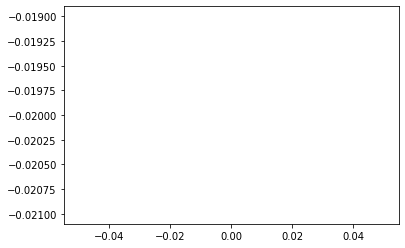

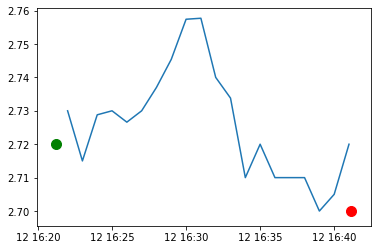

buy time:2020-02-12T16:21:14.680782168Z sell time:2020-02-12T16:41:09.235960091Z
{'rsi': 62.03522143895404, 'macd1': [0.0013847160955191562, 0.0024934921674666377, 0.0027594165296198625, 0.0031118140608836775, 0.004947888319727145], 'macd2': [0.016508800372615262, 0.01633763808953903, 0.016038879606645295, 0.01577354622497218, 0.015824075494812462], 'macd_signal': [0.0018686505405618313, 0.0019936188659427927, 0.0021467783986782066, 0.002339785531119301, 0.00286140608884087]}
{'rsi': 47.565532855917546, 'macd': [0.003970746977114636, 0.0027894267627708302, 0.0013132106637656626, 0.00040559798059591756, -5.23547333104446e-05], 'bail_out': 0, 'too_close': 0, 'macd_signal': [0.006460852727762583, 0.005726567534764233, 0.004843896160564519, 0.003956236524570798, 0.00315451827299455], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0032068730063049946}
GMLP analysis for run 56


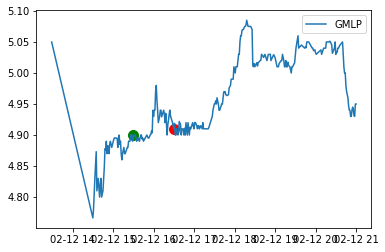

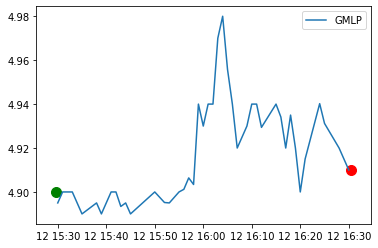

Delta = 0.009999999999999787


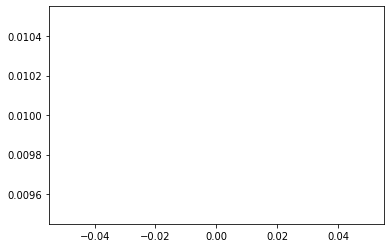

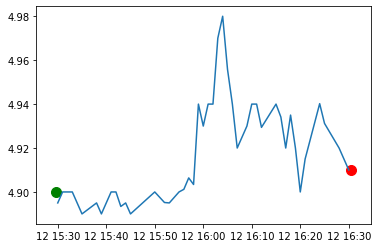

buy time:2020-02-12T15:29:43.894645149Z sell time:2020-02-12T16:30:29.35034281Z
{'rsi': 61.16062209956963, 'macd1': [0.007334924395900444, 0.007634530555242769, 0.00857998232617696, 0.009222943316782306, 0.010020443314358474], 'macd2': [0.019856597500640838, 0.019721036514772194, 0.0197247110551384, 0.019696544830893004, 0.01971909714544129], 'macd_signal': [0.010313976406923645, 0.00977808723658747, 0.009538466254505367, 0.009475361666960756, 0.0095843779964403]}
{'rsi': 45.767249107262096, 'macd': [6.857103672519571e-05, 0.0008587280554754884, 0.0009957500433914745, 0.0005077704230220803, -0.00039854837756436723], 'bail_out': 0, 'too_close': 1, 'macd_signal': [0.003271425766695218, 0.0027888862244512718, 0.0024302589882393122, 0.0020457612751958658, 0.0015568993446438192], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0019554477222081864}
HMI analysis for run 56


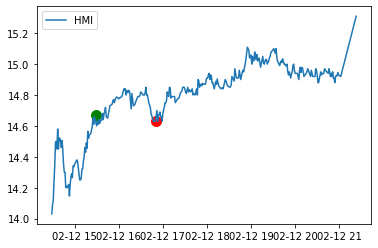

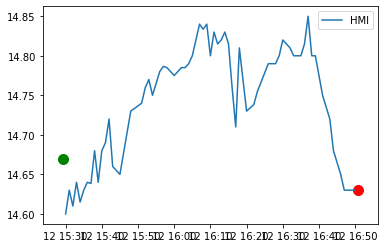

Delta = -0.03999999999999915


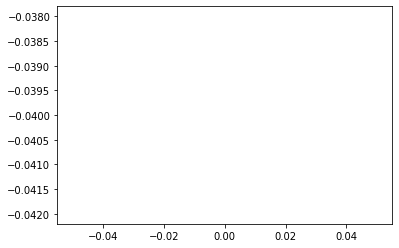

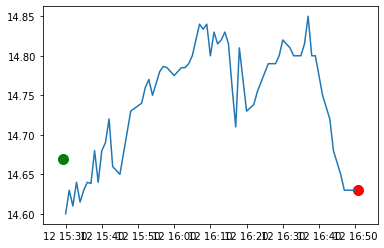

buy time:2020-02-12T15:29:13.134281612Z sell time:2020-02-12T16:50:39.295959389Z
{'rsi': 69.86260461203464, 'macd1': [0.07375484973081292, 0.07864697939239917, 0.0856519587068334, 0.08729230479413452, 0.09236901691615884], 'macd2': [0.08504485468711565, 0.08654874811364799, 0.0886096292739822, 0.08978821745184362, 0.09168856872231679], 'macd_signal': [0.05886649008486731, 0.06282258794637369, 0.06738846209846563, 0.07136923063759941, 0.0755691878933113]}
{'rsi': 31.28943237724394, 'macd': [-0.0007333191343086298, -0.006091086401401213, -0.011745306526389498, -0.01703761692863459, -0.020940227411831103], 'bail_out': 0, 'too_close': 1, 'macd_signal': [0.004858008087940204, 0.0026681891900719205, -0.00021450995322036363, -0.003579131348303209, -0.007051350561008788], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.013888876850822315}
ADTN analysis for run 56


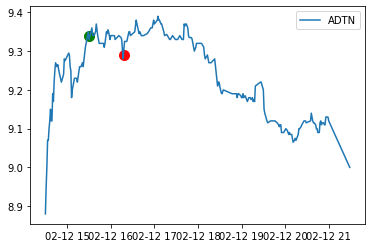

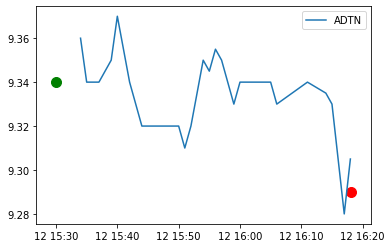

Delta = -0.05000000000000071


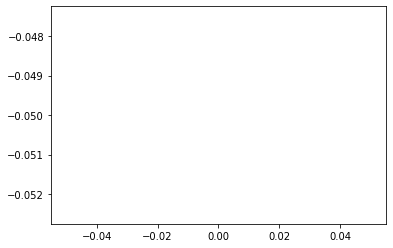

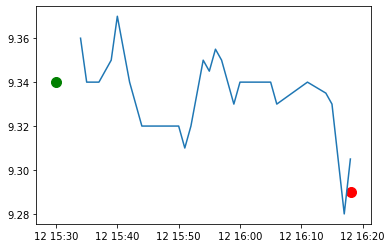

buy time:2020-02-12T15:30:00.89313199Z sell time:2020-02-12T16:18:07.349322966Z
{'rsi': 73.8742622515864, 'macd1': [0.03039678207241714, 0.0331866070862592, 0.03579189326990928, 0.03822290787795524, 0.041287401854310346], 'macd2': [0.0548171720300612, 0.05520119121512046, 0.05562615058335929, 0.05608809656656, 0.056743268626165744], 'macd_signal': [0.03613540004655255, 0.03554564145449388, 0.03559489181757696, 0.036120495029652616, 0.03715387639458416]}
{'rsi': 38.383239451135026, 'macd': [0.005458968388950325, 0.004849905596600479, 0.004052585166242295, 0.002079964244323662, -0.0002633762694355113], 'bail_out': 0, 'too_close': 1, 'macd_signal': [0.008044253056158395, 0.007405383564246812, 0.006734823884645909, 0.0058038519565814595, 0.004590406311378066], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.004853782580813577}
CTK analysis for run 56


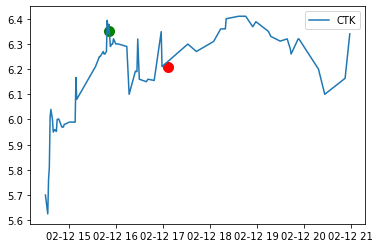

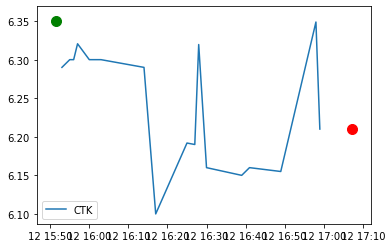

Delta = -0.13999999999999968


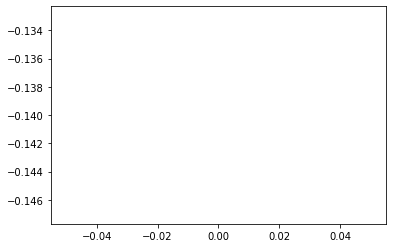

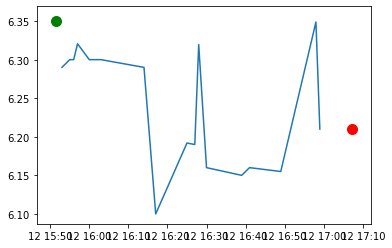

buy time:2020-02-12T15:51:29.460647974Z sell time:2020-02-12T17:07:10.000802207Z
{'rsi': 68.95390148980675, 'macd1': [0.07696043978738487, 0.07959221789615167, 0.0906149247574799, 0.09408610620430391, 0.09864516738111107], 'macd2': [0.04571135691147887, 0.04770158964711868, 0.05143478403581092, 0.05395871092594984, 0.05677827147393355], 'macd_signal': [0.04820690329527879, 0.054483966215453365, 0.06171015792385867, 0.06818534757994772, 0.07427731154018039]}
{'rsi': 50.124411568701035, 'macd': [0.007541248439332016, 0.003492963938255045, 3.335310704866146e-05, 0.007404651769653547, 0.005841966938310961], 'bail_out': 0, 'too_close': 0, 'macd_signal': [0.024034625975565264, 0.019926293568103222, 0.01594770547589231, 0.014239094734644558, 0.012559669175377838], 'data.close <= stop_prices': 1, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.006717702237066877}
AMPY analysis for run 56


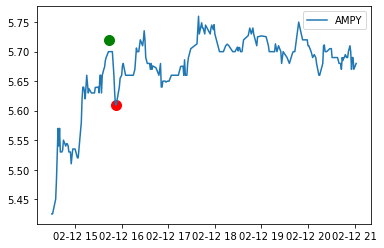

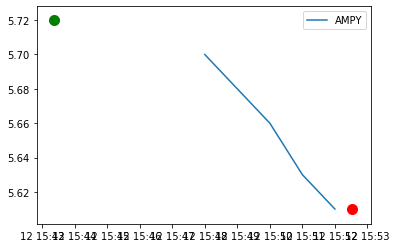

Delta = -0.10999999999999943


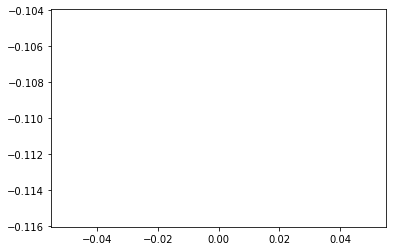

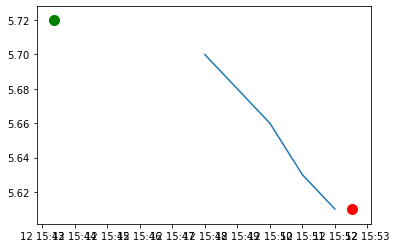

buy time:2020-02-12T15:43:21.852796211Z sell time:2020-02-12T15:52:30.568245563Z
{'rsi': 73.95277495052535, 'macd1': [0.03357510744055148, 0.03358818813323605, 0.03409315804193991, 0.034499124118082314, 0.03681719868921274], 'macd2': [0.0409599680256969, 0.04122456214654857, 0.04157799390324346, 0.0419166322465232, 0.04264095863552697], 'macd_signal': [0.03695997455945951, 0.036285617274214824, 0.03584712542775984, 0.03557752516582434, 0.03582545987050202]}
{'rsi': 44.501513243300934, 'macd': [0.01980731117156065, 0.01993841985121403, 0.01770371986326591, 0.014174035199107315, 0.010200592146528464], 'bail_out': 0, 'too_close': 1, 'macd_signal': [0.019901480067370643, 0.01990886802413932, 0.019467838391964636, 0.01840907775339317, 0.01676738063202023], 'data.close <= stop_prices': 1, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.006566788485491765}
VSLR analysis for run 56


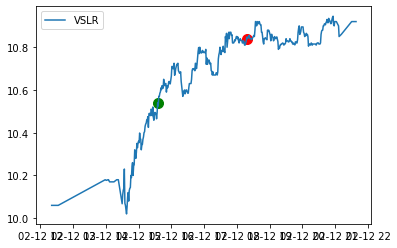

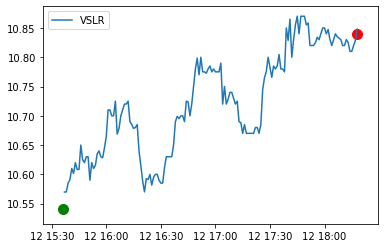

Delta = 0.3000000000000007


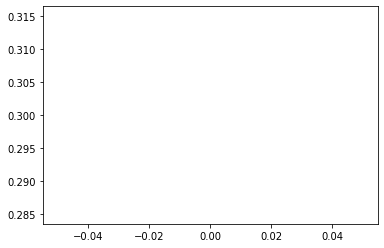

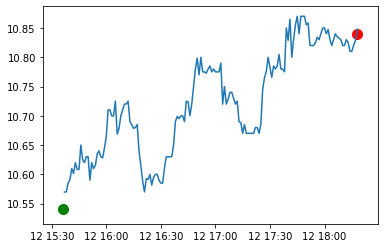

buy time:2020-02-12T15:36:07.060623859Z sell time:2020-02-12T18:18:08.306098939Z
{'rsi': 64.09659758329246, 'macd1': [0.03669155211908226, 0.0326343667961293, 0.031468943915797354, 0.03379496366578394, 0.03522423881274506], 'macd2': [0.05366570095897849, 0.05292198679623006, 0.05263131337133409, 0.05300101956718706, 0.053254794008765316], 'macd_signal': [0.04430227874546349, 0.04196869635559665, 0.03986874586763679, 0.03865398942726622, 0.03796803930436199]}
{'rsi': 55.6161680408238, 'macd': [-0.0007599154094553029, -0.0015786279906198075, -0.001676603664376941, -0.0012792262197152127, -0.00036595514309922805], 'bail_out': 0, 'too_close': 0, 'macd_signal': [0.0018022187865873625, 0.0011260494311459285, 0.0005655188120413545, 0.00019656980569004106, 8.406481593218723e-05], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 1, 'distance_macd_to_signal_macd': -0.0004500199590314153}
TRIL analysis for run 56


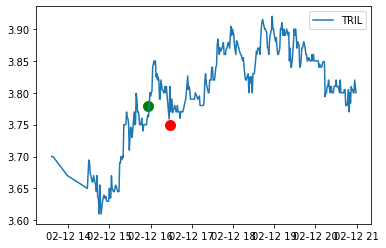

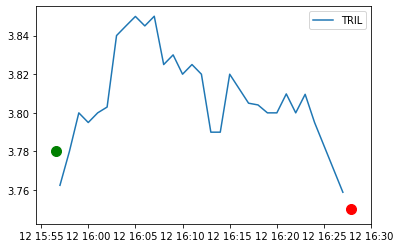

Delta = -0.029999999999999805


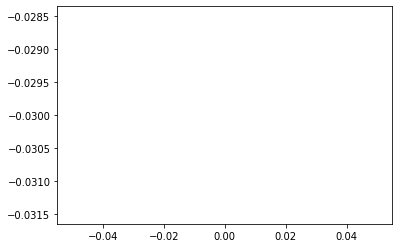

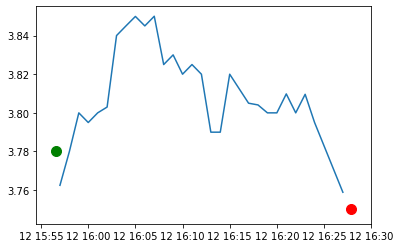

buy time:2020-02-12T15:56:36.820536184Z sell time:2020-02-12T16:27:53.307350254Z
{'rsi': 61.89794531255802, 'macd1': [0.009356770183677199, 0.008405122411202282, 0.007563744556286611, 0.007616069660768332, 0.009165713891792215], 'macd2': [0.0183461706757444, 0.01807274955478988, 0.017792288540181556, 0.017665735182014863, 0.017840920220851597], 'macd_signal': [0.014660078628003767, 0.01340908738464347, 0.012240018818972099, 0.011315228987331345, 0.01088532596822352]}
{'rsi': 37.41932763816147, 'macd': [0.0027785816065528657, 0.0021045525118568165, 0.002050704483368193, 0.0012236708964503684, -0.001311987364738254], 'bail_out': 0, 'too_close': 1, 'macd_signal': [0.005802526941248131, 0.0050629320553698684, 0.0044604865409695335, 0.0038131234120657004, 0.0027881012567049094], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.004100088621443163}
MOV analysis for run 56


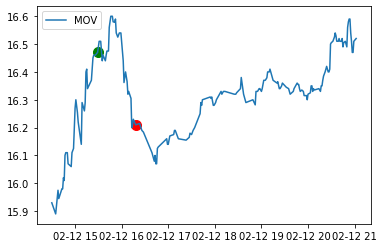

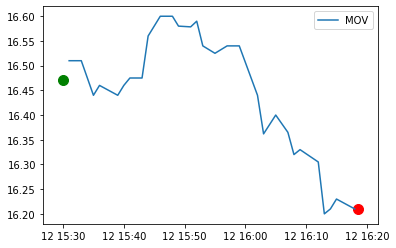

Delta = -0.259999999999998


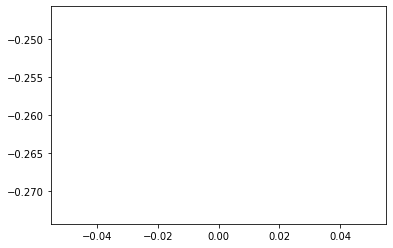

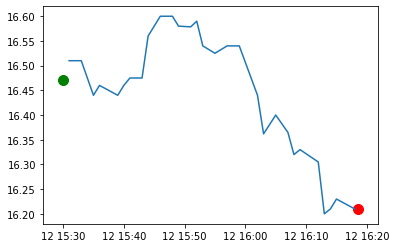

buy time:2020-02-12T15:29:58.056842777Z sell time:2020-02-12T16:18:29.032895172Z
{'rsi': 71.54440258389288, 'macd1': [0.11334477130044363, 0.11803011222263748, 0.12115361166626215, 0.12222012990082476, 0.12246061991478996], 'macd2': [0.07049404557703909, 0.07386603088768595, 0.07701016286539186, 0.07977969786308847, 0.0823600981982544], 'macd_signal': [0.10585697848659695, 0.10829160523380506, 0.11086400652029647, 0.11313523119640213, 0.1150003089400797]}
{'rsi': 30.481312770452128, 'macd': [-0.010546902909997158, -0.016099572413487806, -0.025671787969276494, -0.03227777687029132, -0.037006108781856284], 'bail_out': 0, 'too_close': 0, 'macd_signal': [0.014146545623697429, 0.00809732201626038, 0.0013435000191530056, -0.005380755358735859, -0.011705826043359943], 'data.close <= stop_prices': 1, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.02530028273849634}
CRC analysis for run 56


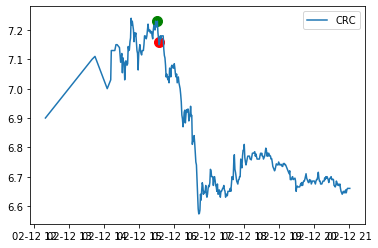

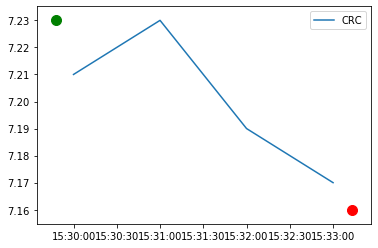

Delta = -0.07000000000000028


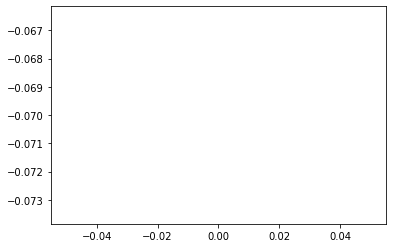

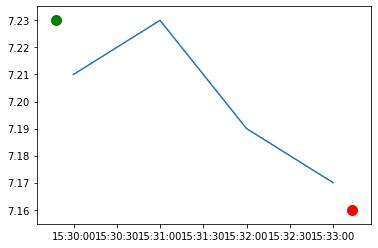

buy time:2020-02-12T15:29:47.88241252Z sell time:2020-02-12T15:33:12.813393293Z
{'rsi': 63.11821559828208, 'macd1': [0.015195498484349201, 0.01540419082604405, 0.016612662708271664, 0.01694736104667527, 0.018611898365406], 'macd2': [0.03770198890494658, 0.03735600206121514, 0.037222639511966804, 0.03695564319694533, 0.03697076471087879], 'macd_signal': [0.0191114922113046, 0.01837003193425249, 0.018018558089056325, 0.017804318680580113, 0.01796583461754529]}
{'rsi': 43.96772060198026, 'macd': [0.010495381338188281, 0.010019448350460536, 0.010557429810017283, 0.008761604586165816, 0.005690031624902225], 'bail_out': 0, 'too_close': 1, 'macd_signal': [0.009847295267624505, 0.00988172588419171, 0.010016866669356824, 0.009765814252718623, 0.008950657727155344], 'data.close <= stop_prices': 1, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0032606261022531183}
MSGN analysis for run 56


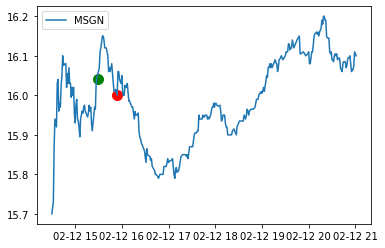

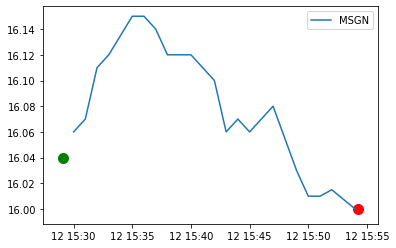

Delta = -0.03999999999999915


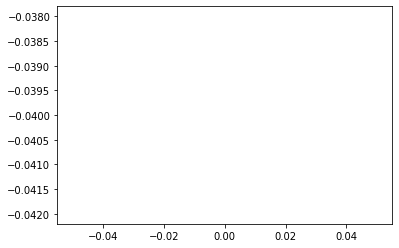

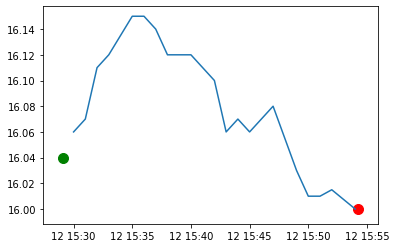

buy time:2020-02-12T15:29:04.876278935Z sell time:2020-02-12T15:54:12.348859917Z
{'rsi': 63.41296232737355, 'macd1': [0.0016210764160202729, 0.003135839562974141, 0.0038880233440590217, 0.009618218348109053, 0.01519465923905372], 'macd2': [0.05755121485233872, 0.056477988293416104, 0.055320288867084955, 0.05520627545826606, 0.05525298879072338], 'macd_signal': [0.007726412974264292, 0.006808298292006262, 0.006224243302416814, 0.006903038311555262, 0.008561362497054954]}
{'rsi': 38.38244523241866, 'macd': [0.006140023510248227, 0.00215774765492327, -0.0009733471369521851, -0.0031407801288416692, -0.005568120380591068], 'bail_out': 0, 'too_close': 0, 'macd_signal': [0.01476276680222174, 0.012241762972762046, 0.009598740950819199, 0.007050836734887026, 0.004527045311791407], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.010095165692382476}
EROS analysis for run 56


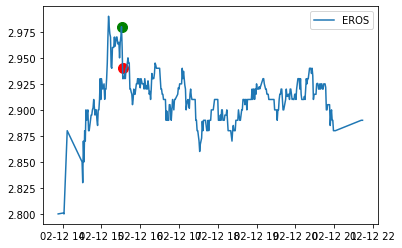

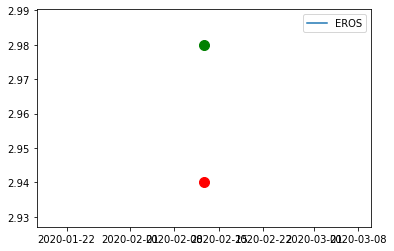

Delta = -0.040000000000000036


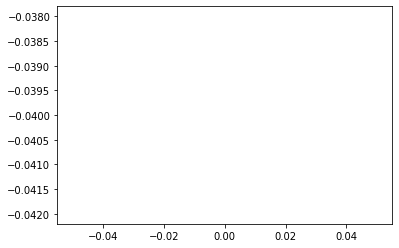

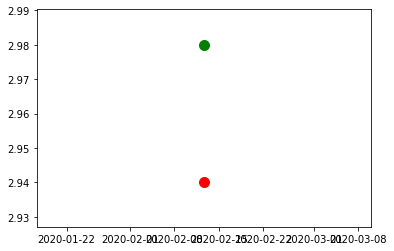

buy time:2020-02-12T15:32:02.272465086Z sell time:2020-02-12T15:33:23.274766287Z
{'rsi': 61.793912734191935, 'macd1': [0.009770683507260625, 0.009393446665369343, 0.009389703308726904, 0.01007748611125825, 0.010501504134765138], 'macd2': [0.01344246477954325, 0.013416184332390557, 0.013450516181159777, 0.013620526384795717, 0.013755157081727809], 'macd_signal': [0.012958100337230393, 0.012245169602858184, 0.011674076344031928, 0.011354758297477192, 0.01118410746493478]}
{'rsi': 44.669350921684355, 'macd': [0.004985227581904894, 0.005003145345266358, 0.0054716118447002415, 0.0047266297423798065, 0.0030457783672939165], 'bail_out': 0, 'too_close': 1, 'macd_signal': [0.006831601046681424, 0.006465909906398411, 0.006267050294058777, 0.005958966183722983, 0.005376328620437169], 'data.close <= stop_prices': 1, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0023305502531432527}
KLXE analysis for run 56


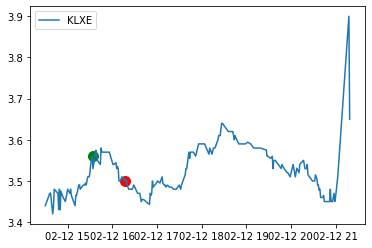

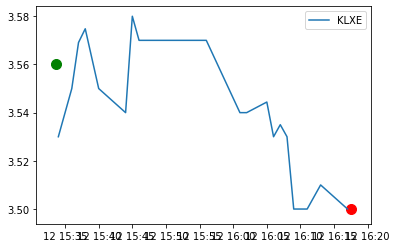

Delta = -0.06000000000000005


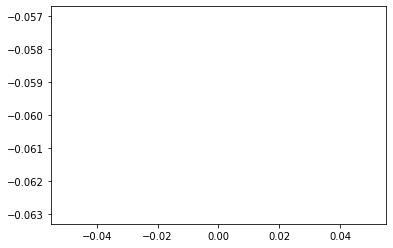

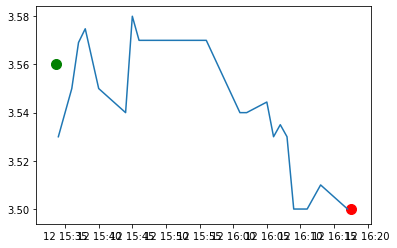

buy time:2020-02-12T15:33:42.816770561Z sell time:2020-02-12T16:17:32.52291881Z
{'rsi': 71.1996997524001, 'macd1': [0.021395196730485733, 0.02150853105662165, 0.02214993508927421, 0.02399548029902432, 0.026763409106674185], 'macd2': [0.018229832759673048, 0.018625604600218892, 0.01911987432700668, 0.01986391077004157, 0.02083655059904732], 'macd_signal': [0.02121830246966611, 0.021276348187057217, 0.021451065567500614, 0.021959948513805356, 0.02292064063237912]}
{'rsi': 40.32948113617824, 'macd': [0.0035159162120237397, 0.0008572566618281208, -0.0012255593079588678, -0.0023131359167800625, -0.0036500380026565082], 'bail_out': 0, 'too_close': 0, 'macd_signal': [0.008565726920010255, 0.007024032868373828, 0.005374114433107289, 0.003836664363129819, 0.002339323889972553], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.005989361892629061}
SVRA analysis for run 56


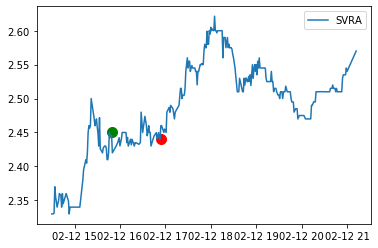

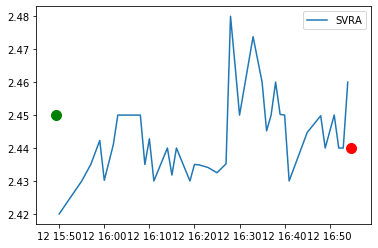

Delta = -0.010000000000000231


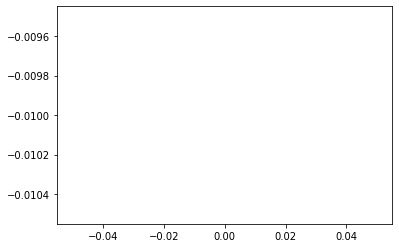

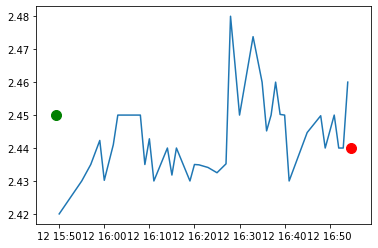

buy time:2020-02-12T15:49:22.874920479Z sell time:2020-02-12T16:54:45.467406737Z
{'rsi': 57.154714209724744, 'macd1': [0.005371099559671411, 0.004302239845614508, 0.005808948162571603, 0.006316950995941539, 0.0072492386745541815], 'macd2': [0.016471484876492415, 0.016091993845201102, 0.01619692113893123, 0.016146001514107944, 0.016194881936828942], 'macd_signal': [0.01379423097330445, 0.011895832747766462, 0.01067845583072749, 0.0098061548637703, 0.009294771625927076]}
{'rsi': 48.32150854006325, 'macd': [0.0007400757680269265, 0.0008353973451180607, 0.0003793440630452949, 1.9051322948548943e-05, -0.00026194368651566435], 'bail_out': 0, 'too_close': 0, 'macd_signal': [0.0020314079194521948, 0.001792205804585368, 0.0015096334562773534, 0.0012115170296115925, 0.0009168248863861411], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0011787685729018056}
TGH analysis for run 56


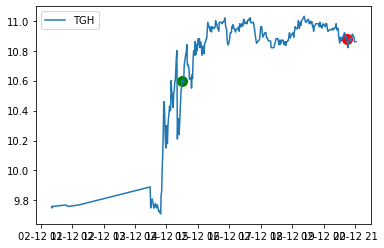

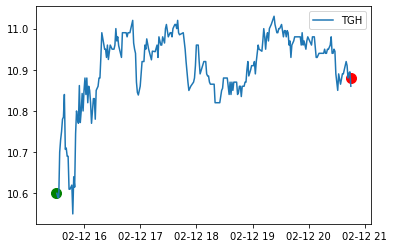

Delta = 0.28000000000000114


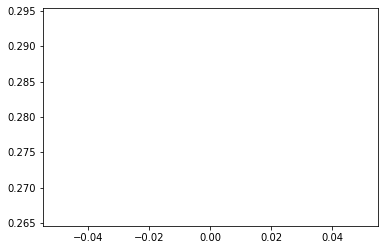

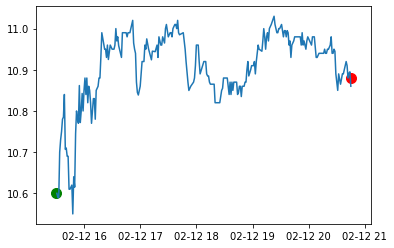

buy time:2020-02-12T15:30:35.577457964Z sell time:2020-02-12T20:45:18.31688988Z
{'rsi': 57.133830244444795, 'macd1': [0.06529099535815597, 0.04670996181039477, 0.05156288467969539, 0.05557514180316758, 0.062073917135766266], 'macd2': [0.09970722234080931, 0.096160306242286, 0.09674163564345761, 0.09728168858608832, 0.09842264622969132], 'macd_signal': [0.11610578858802242, 0.1022266232324969, 0.0920938755219366, 0.08479012877818279, 0.08024688644969949]}
{'rsi': 0, 'macd': [], 'bail_out': 0, 'too_close': 0, 'macd_signal': [], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0}
LOGC analysis for run 56


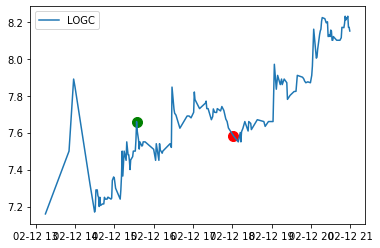

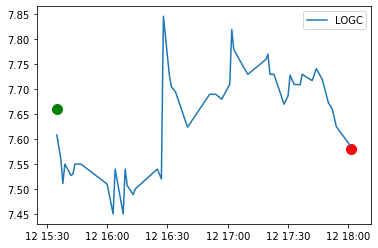

Delta = -0.08000000000000007


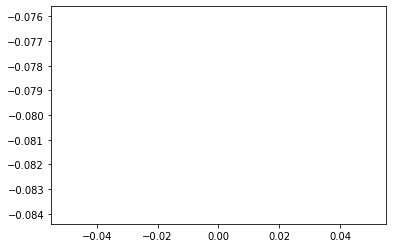

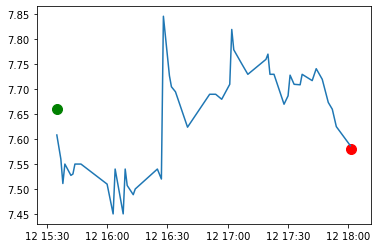

buy time:2020-02-12T15:34:53.568880236Z sell time:2020-02-12T18:01:25.506656994Z
{'rsi': 67.83970574671847, 'macd1': [0.05991319136808748, 0.06039930354027678, 0.06009184950378277, 0.06395248409623111, 0.07422560254790689], 'macd2': [0.05442102429386786, 0.055412936374501065, 0.056236901969079156, 0.057864649760061226, 0.0608690436297179], 'macd_signal': [0.06505422791790053, 0.06412324304237578, 0.06331696433465718, 0.06344406828697197, 0.06560037513915895]}
{'rsi': 39.195783819904946, 'macd': [0.012948932225835819, 0.009381406453567998, 0.00577318628746859, 0.0010736226997609677, -0.004597123247799928], 'bail_out': 0, 'too_close': 1, 'macd_signal': [0.018167519157628622, 0.0164102966168165, 0.014282874550946918, 0.011641024180709728, 0.008393394695007796], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.012990517942807724}
LAC analysis for run 56


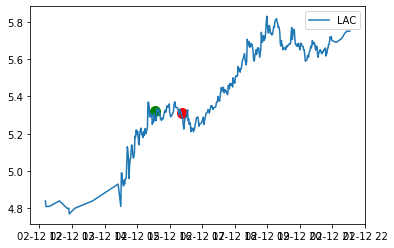

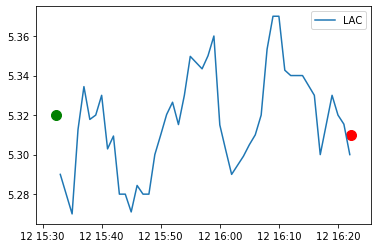

Delta = -0.010000000000000675


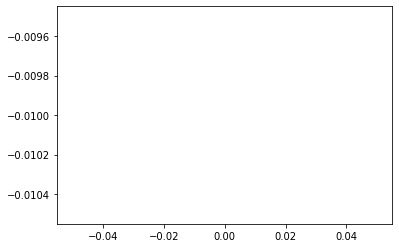

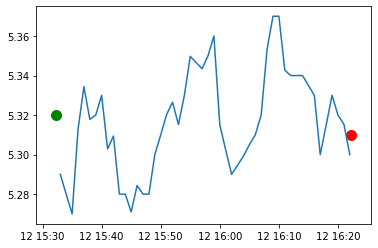

buy time:2020-02-12T15:32:20.710158023Z sell time:2020-02-12T16:22:13.640272177Z
{'rsi': 61.30411596753815, 'macd1': [0.04063811564107134, 0.03697004655296787, 0.03287717138077273, 0.03328443816744908, 0.0348196535909997], 'macd2': [0.058891707703455864, 0.058207034612002495, 0.05732408342372519, 0.05721973835458449, 0.05735209462907065], 'macd_signal': [0.04606731755890402, 0.044247863357716785, 0.04197372496232797, 0.040235867603352196, 0.0391526248008817]}
{'rsi': 46.17385936099592, 'macd': [0.0028108257174395135, 0.0025379730257100164, 0.001772919330521816, 0.000914787628680358, -4.6286264036687896e-05], 'bail_out': 0, 'too_close': 1, 'macd_signal': [0.0055333083066632285, 0.004934241250472586, 0.004301976866482432, 0.003624539018922017, 0.002890373962330276], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.002936660226366964}
SLDB analysis for run 56


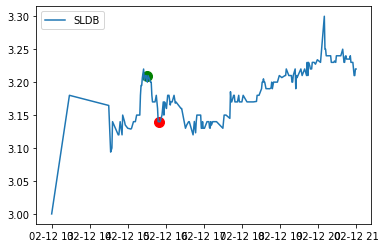

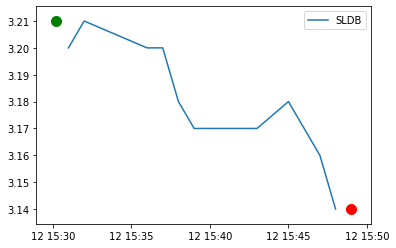

Delta = -0.06999999999999984


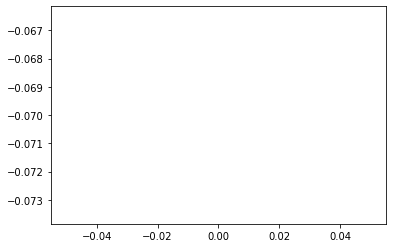

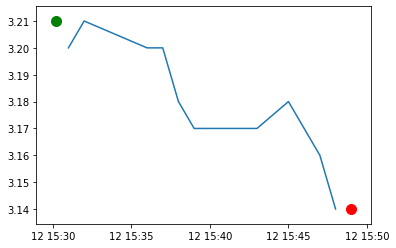

buy time:2020-02-12T15:30:12.749355153Z sell time:2020-02-12T15:49:00.277236802Z
{'rsi': 65.90832693570015, 'macd1': [0.021428148062313745, 0.02376912460163849, 0.026393318476019445, 0.02676847528955406, 0.02734766110882436], 'macd2': [0.0072986597386890395, 0.008369662539638778, 0.009554348183311578, 0.010352326701247527, 0.011188288021905635], 'macd_signal': [0.015952803635051273, 0.017516067828368717, 0.019291517957898862, 0.0207869094242299, 0.022099059761148794]}
{'rsi': 38.6861999045305, 'macd': [0.004555341749243436, 0.004042055628213248, 0.0030701176686025455, 0.0017534112368462473, -0.0003343263883777148], 'bail_out': 0, 'too_close': 1, 'macd_signal': [0.009365704026686983, 0.008300974346992236, 0.007254803011314298, 0.006154524656420688, 0.004856754447461008], 'data.close <= stop_prices': 1, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.005191080835838723}
TALO analysis for run 56


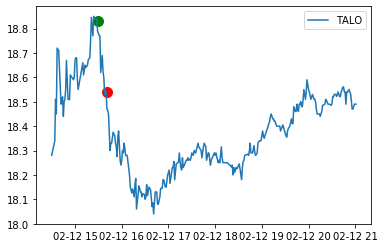

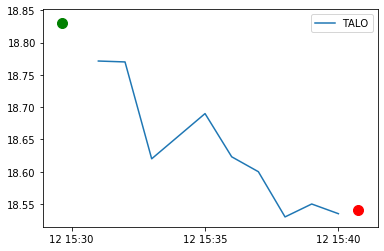

Delta = -0.28999999999999915


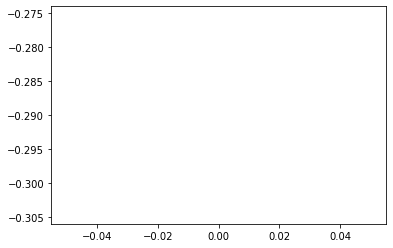

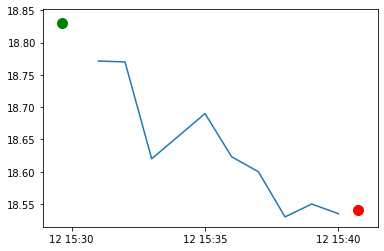

buy time:2020-02-12T15:29:38.202147229Z sell time:2020-02-12T15:40:43.681224883Z
{'rsi': 65.64396435816327, 'macd1': [0.09310771198184398, 0.0932606822442672, 0.09869949732458139, 0.10103817583679842, 0.10171904161318679], 'macd2': [0.09970868001889599, 0.10075636982232439, 0.10283862042544456, 0.10442994555782192, 0.10572699447720169], 'macd_signal': [0.09157143799764404, 0.09190928684696867, 0.0932673289424912, 0.09482149832135264, 0.09620100697971948]}
{'rsi': 42.45929046844953, 'macd': [0.021961726866415177, 0.013975855740419263, 0.003935230762493802, -0.002900778710724694, -0.008418438316990517], 'bail_out': 0, 'too_close': 0, 'macd_signal': [0.04091083312214228, 0.03552383764579768, 0.029206116269136904, 0.022784737273164584, 0.016544102155133564], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.02496254047212408}
SGBX analysis for run 56


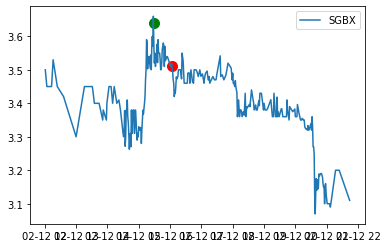

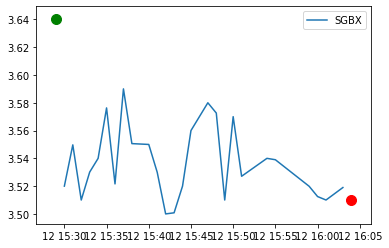

Delta = -0.13000000000000034


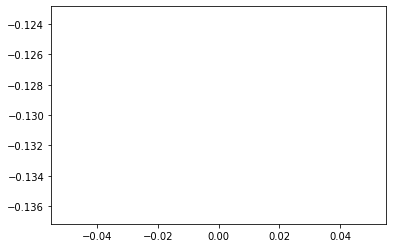

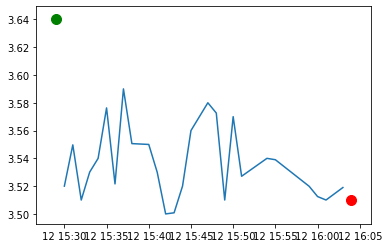

buy time:2020-02-12T15:29:02.302173059Z sell time:2020-02-12T16:03:59.375909877Z
{'rsi': 68.06216221564442, 'macd1': [0.05032875078136012, 0.04648165830899398, 0.04851391738837618, 0.05194644040056007, 0.05803236081864682], 'macd2': [0.01145676283395236, 0.012229493883410214, 0.014038824618824108, 0.016160821709472195, 0.0188869600616286], 'macd_signal': [0.044988598004898794, 0.04528721006571783, 0.0459325515302495, 0.047135329304311614, 0.04931473560717865]}
{'rsi': 48.4647872627893, 'macd': [0.00397455798178159, 0.0023885914637742367, 0.0007373371450181132, -0.0006888004688829774, -0.0013235986034954017], 'bail_out': 0, 'too_close': 0, 'macd_signal': [0.006759850646582673, 0.005885598810020986, 0.004855946477020411, 0.003746997087839733, 0.002732877949572706], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.004056476553068108}
AVXL analysis for run 56


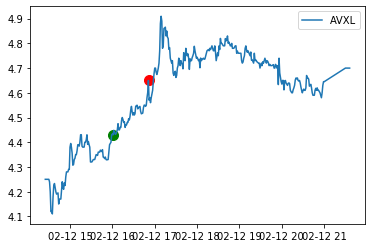

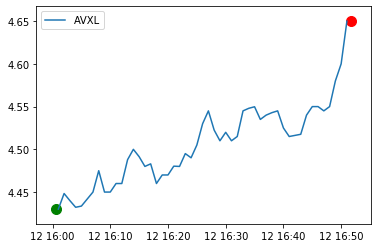

Delta = 0.22000000000000064


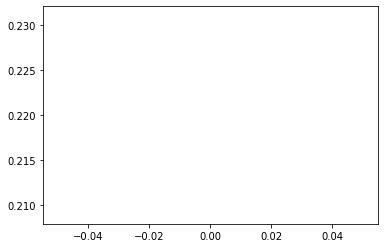

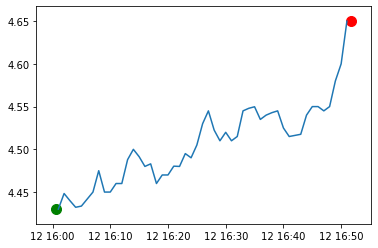

buy time:2020-02-12T16:00:40.064150541Z sell time:2020-02-12T16:51:44.341964435Z
{'rsi': 71.06103984497254, 'macd1': [-0.006010658066026409, -0.004080100242816798, -0.00013587288568306377, 0.003753602939827516, 0.009151299350813602], 'macd2': [0.013309161118270296, 0.013139534225356186, 0.013440665925676498, 0.013856156281027765, 0.014696067789440548], 'macd_signal': [-0.0027396794758259117, -0.0030077636292240887, -0.0024333854805158837, -0.0011959877964472037, 0.0008734696330049575]}
{'rsi': 78.32868854104747, 'macd': [0.008899256930830823, 0.008662273016551758, 0.00862485343378161, 0.010042125792223189, 0.01413295976253881], 'bail_out': 0, 'too_close': 0, 'macd_signal': [0.010316230401921611, 0.00998543892484764, 0.009713321826634435, 0.009779082619752185, 0.01064985804830951], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0034831017142292996}
DO analysis for run 56


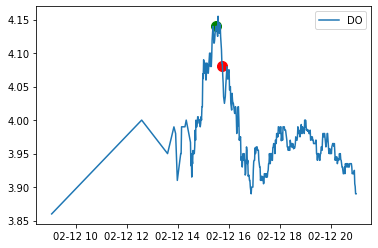

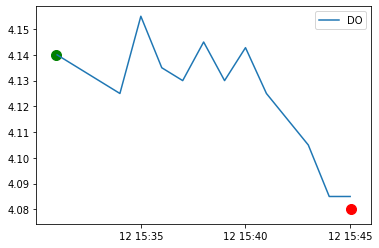

Delta = -0.05999999999999961


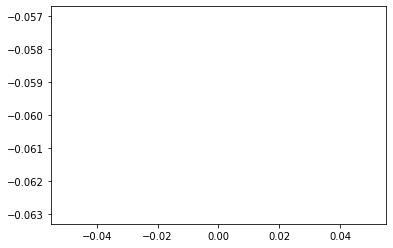

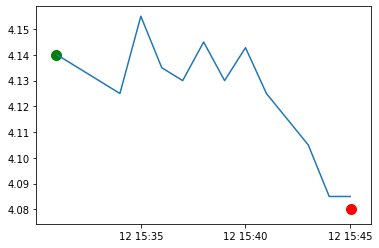

buy time:2020-02-12T15:30:58.182144628Z sell time:2020-02-12T15:45:02.784791322Z
{'rsi': 65.54615848074656, 'macd1': [0.02382830370281752, 0.022616202186493517, 0.02260539670006878, 0.02273817990358218, 0.02298194816954169], 'macd2': [0.02744415651288179, 0.027406187624158918, 0.027567326703147543, 0.027751457736310492, 0.02795644761090621], 'macd_signal': [0.02350423591115793, 0.023326629166225046, 0.023182382672993794, 0.023093542119111472, 0.023071223329197515]}
{'rsi': 39.55004760823822, 'macd': [0.0072713662532279955, 0.005728426899578309, 0.00393226082011644, 0.0014426215267677733, -0.0007758327476174998], 'bail_out': 0, 'too_close': 1, 'macd_signal': [0.009576639948829105, 0.008806997338978946, 0.007832050035206446, 0.006554164333518711, 0.005088164917291469], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.005863997664908969}
ECOM analysis for run 56


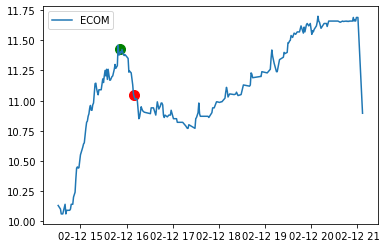

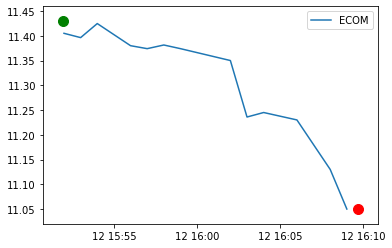

Delta = -0.379999999999999


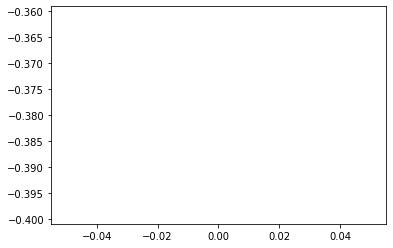

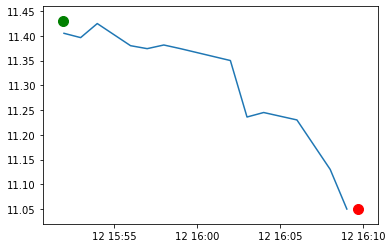

buy time:2020-02-12T15:51:55.762167155Z sell time:2020-02-12T16:09:39.475573393Z
{'rsi': 69.95051826064555, 'macd1': [0.11442341498849551, 0.11185583769790775, 0.12213074622866671, 0.12240731848235242, 0.1269247774448452], 'macd2': [0.17878787104183225, 0.17816599665113664, 0.18002781314070226, 0.18017332633139738, 0.18116098428679983], 'macd_signal': [0.13216094453028276, 0.12809992316380775, 0.12690608777677953, 0.12600633391789412, 0.12619002262328433]}
{'rsi': 33.98715766106874, 'macd': [0.03565772285465485, 0.027673823981452017, 0.020313982989588197, 0.009120418801257912, -0.0038761301610943377], 'bail_out': 0, 'too_close': 1, 'macd_signal': [0.05292795942679078, 0.047877132337723026, 0.04236450246809606, 0.03571568573472843, 0.027797322555563872], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.03167345271665821}
VNET analysis for run 56


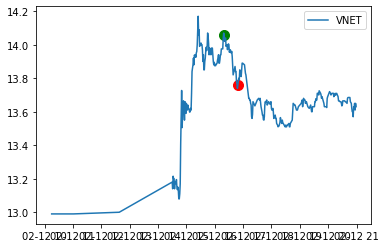

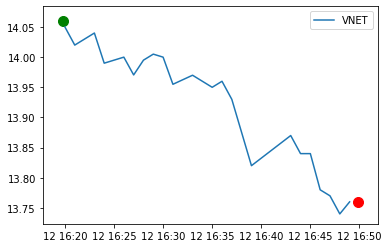

Delta = -0.3000000000000007


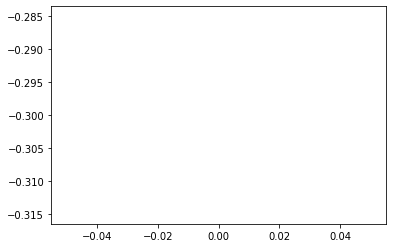

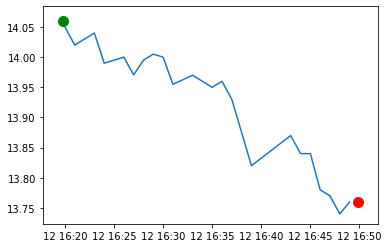

buy time:2020-02-12T16:19:46.455607103Z sell time:2020-02-12T16:49:48.90117733Z
{'rsi': 71.33029673809396, 'macd1': [0.0015311545404834703, 0.005415003541346053, 0.008396195738134438, 0.015821389673073227, 0.02382777934092495], 'macd2': [0.0505151669517403, 0.04989959097319918, 0.049253433959799864, 0.04961975902030602, 0.05035243991920346], 'macd_signal': [-0.006156302019584432, -0.003842040907398335, -0.0013943935782917802, 0.0020487630719812212, 0.006404566325769967]}
{'rsi': 32.04852740254805, 'macd': [-0.018386090601703486, -0.02357716205040461, -0.027835436399389124, -0.032350514640162586, -0.03440965983245192], 'bail_out': 0, 'too_close': 0, 'macd_signal': [-0.005793758980905788, -0.009350439594805552, -0.013047438955722267, -0.01690805409261033, -0.02040837524057865], 'data.close <= stop_prices': 1, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.014001284591873272}
GLOG analysis for run 56


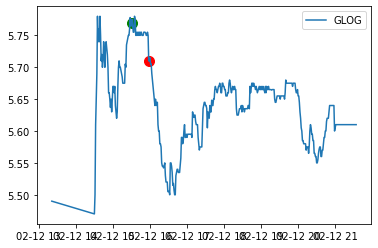

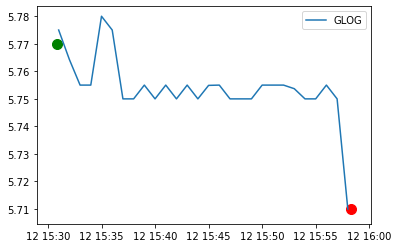

Delta = -0.05999999999999961


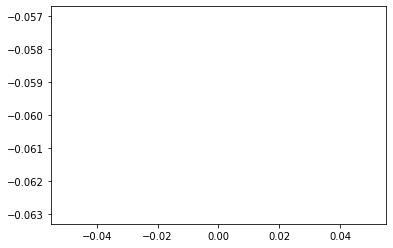

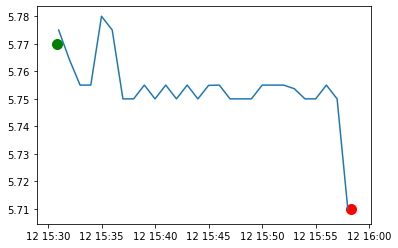

buy time:2020-02-12T15:30:48.119244283Z sell time:2020-02-12T15:58:19.497607625Z
{'rsi': 69.20923614522697, 'macd1': [0.022747171938855892, 0.024317011485996964, 0.026705723251010838, 0.027235845309059314, 0.027739663499164458], 'macd2': [0.03717717900966733, 0.03735564750462572, 0.03774798393680534, 0.03784065654564106, 0.03794536548076621], 'macd_signal': [0.017255442527504623, 0.01866775631920309, 0.02027534970556464, 0.021667448826263574, 0.02288189176084375]}
{'rsi': 31.519689474747548, 'macd': [0.0020526272838310433, 0.0017136700300710572, 0.0016870322994790854, 0.0013846258561667213, -0.0009209457341565752], 'bail_out': 0, 'too_close': 1, 'macd_signal': [0.0034930517243236723, 0.0031371753854731494, 0.0028471467682743366, 0.0025546425858528135, 0.0018595249218509359], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.002780470656007511}
PW analysis for run 56


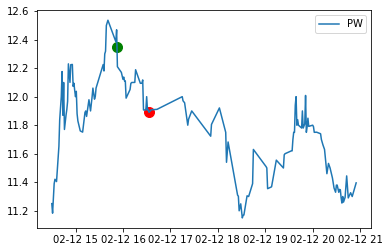

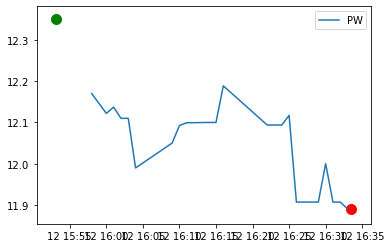

Delta = -0.4599999999999991


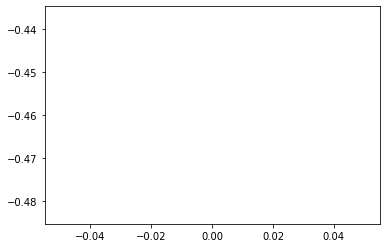

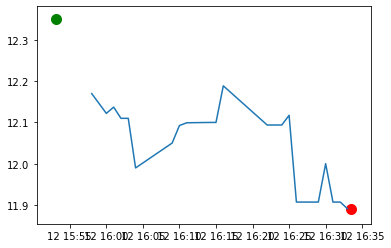

buy time:2020-02-12T15:53:06.858922508Z sell time:2020-02-12T16:33:30.517704742Z
{'rsi': 62.89699779519224, 'macd1': [0.10819222206617418, 0.11934644864925481, 0.14110037034654788, 0.1594636950911923, 0.1600758304883776], 'macd2': [0.20595141947573126, 0.20685523746074885, 0.21023799005318367, 0.21360094957136866, 0.21395591400681724], 'macd_signal': [0.08951454677321508, 0.09548092714842302, 0.10460481578804799, 0.11557659164867685, 0.124476439416617]}
{'rsi': 40.46788768161293, 'macd': [-0.031308093863081865, -0.029650862542585088, -0.03281080096112632, -0.034846976339714786, -0.0368329964225147], 'bail_out': 0, 'too_close': 0, 'macd_signal': [-0.011170994774468283, -0.014866968328091644, -0.018455734854698577, -0.02173398315170182, -0.024753785805864396], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0120792106166503}
VIR analysis for run 56


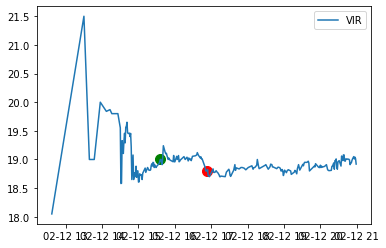

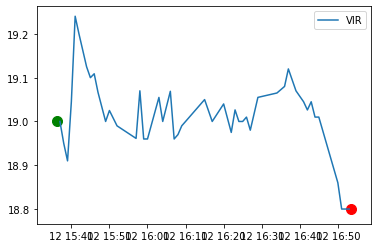

Delta = -0.1999999999999993


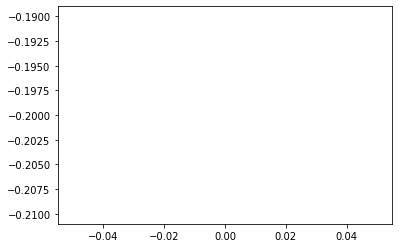

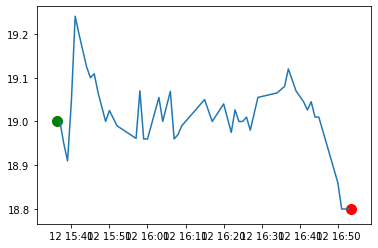

buy time:2020-02-12T15:36:06.64025764Z sell time:2020-02-12T16:53:31.466272265Z
{'rsi': 55.933804071672455, 'macd1': [0.01650526058721269, 0.014769179079902273, 0.0148361331231186, 0.018708121241047593, 0.0271125777865322], 'macd2': [0.06536122595237259, 0.06382624643210022, 0.06263180706309512, 0.06223239394181235, 0.06288494125574928], 'macd_signal': [-0.0009194727874857322, 0.002218257585991869, 0.004741832693417216, 0.007535090402943291, 0.011450587879661073]}
{'rsi': 33.61396368842895, 'macd': [0.006218978052725532, 0.0041944321895925896, -0.0052298169529727545, -0.015622351129607637, -0.023205853720106973], 'bail_out': 0, 'too_close': 1, 'macd_signal': [0.008075620034230194, 0.007299382465302673, 0.004793542581647587, 0.0007103638393965422, -0.0040728796725041615], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.01913297404760281}
ARDX analysis for run 56


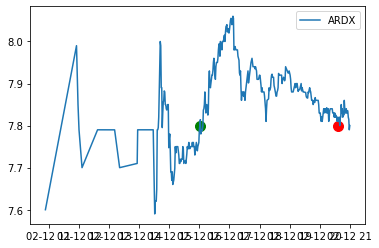

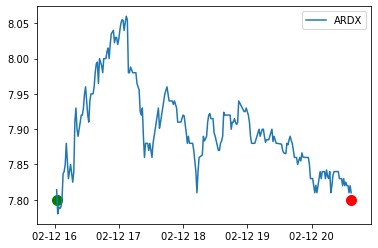

Delta = 0.0


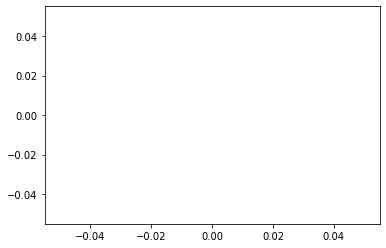

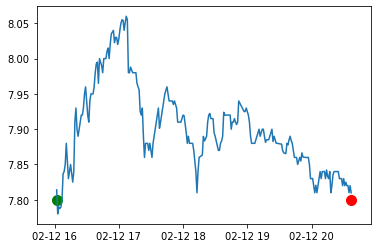

buy time:2020-02-12T16:01:58.574746951Z sell time:2020-02-12T20:37:03.383724221Z
{'rsi': 65.07491489401144, 'macd1': [0.003021508429708497, 0.0030751088304157292, 0.0038797802688002037, 0.006859169227434236, 0.00991300195311684], 'macd2': [0.016981110356730333, 0.016611301263044886, 0.01640443363824584, 0.0166676802839012, 0.017043154018614892], 'macd_signal': [0.003839922653174555, 0.00368695988862279, 0.0037255239646582726, 0.004352253017213465, 0.00546440280439414]}
{'rsi': 36.41333411018836, 'macd': [-0.002774603790713037, -0.002930071267243761, -0.0035326424013293334, -0.0034368193577423156, -0.004356479072378683], 'bail_out': 0, 'too_close': 1, 'macd_signal': [-0.002430018615632105, -0.0025300291459544365, -0.002730551797029416, -0.002871805309171996, -0.0031687400618133333], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0011877390105653495}
OESX analysis for run 56


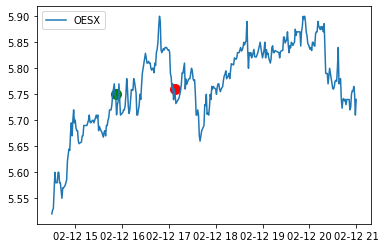

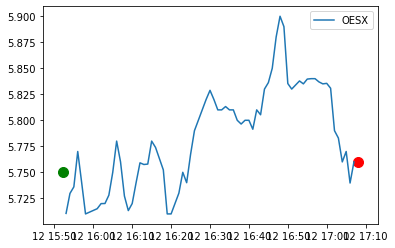

Delta = 0.009999999999999787


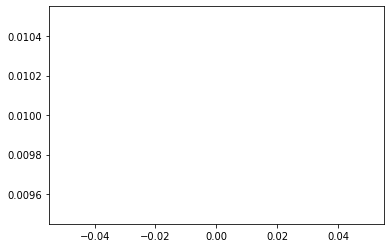

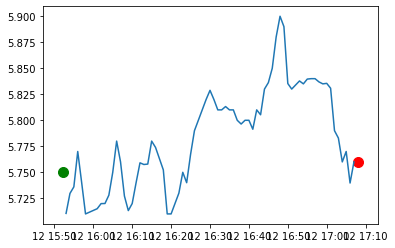

buy time:2020-02-12T15:52:11.123217823Z sell time:2020-02-12T17:07:57.401268746Z
{'rsi': 65.99170616769541, 'macd1': [0.010679194878307818, 0.01339428564873657, 0.016166572883133057, 0.018952079145032386, 0.019323036140593608], 'macd2': [0.022715814497904496, 0.023051629965689102, 0.023483659102637944, 0.02400351692259317, 0.024123540423603984], 'macd_signal': [0.007043760268408433, 0.00831386534447406, 0.00988440685220586, 0.011697941310771166, 0.013222960276735654]}
{'rsi': 33.671167165911555, 'macd': [-0.0008314408506597815, -0.00405498033401841, -0.005994686680349304, -0.009002319071251819, -0.01069395055674427], 'bail_out': 0, 'too_close': 0, 'macd_signal': [0.005001896222259808, 0.0031905209110041645, 0.0013534793927334706, -0.0007176803000635873, -0.0027129343513997237], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.007981016205344546}
ZAGG analysis for run 56


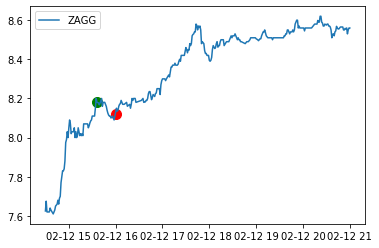

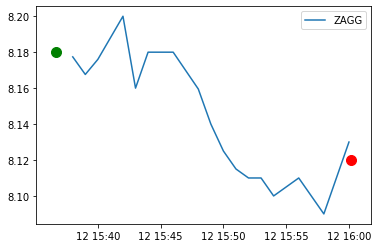

Delta = -0.0600000000000005


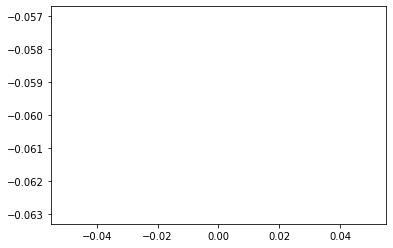

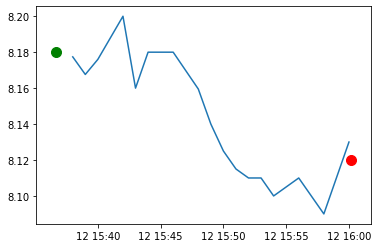

buy time:2020-02-12T15:36:40.937436383Z sell time:2020-02-12T16:00:10.471388985Z
{'rsi': 74.09702527008601, 'macd1': [0.03928660982900389, 0.038596531039424065, 0.04080690770241091, 0.04606225229361094, 0.0480593199671322], 'macd2': [0.06551175379551388, 0.06521905344735579, 0.06548519510473216, 0.0664249996521944, 0.0668635403419593], 'macd_signal': [0.04184722179066344, 0.04119708364041556, 0.04111904845281463, 0.042107689220973896, 0.043298015370205556]}
{'rsi': 51.50924744480937, 'macd': [0.004516342156573927, 0.003006252406628107, 0.0007515558169739478, 2.3849957281996126e-05, -2.402278997415408e-05], 'bail_out': 0, 'too_close': 0, 'macd_signal': [0.013572114665086246, 0.011458942213394618, 0.009317464934110484, 0.007458741938744786, 0.0059621889930009985], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0059862117829751526}
AMRS analysis for run 56


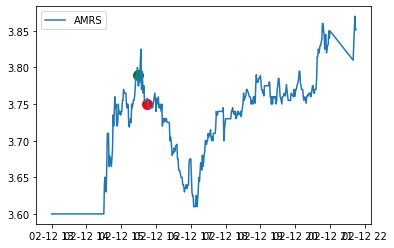

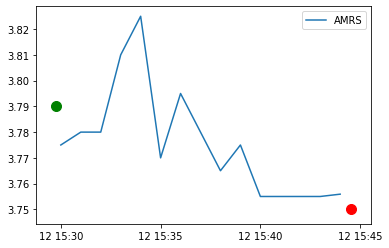

Delta = -0.040000000000000036


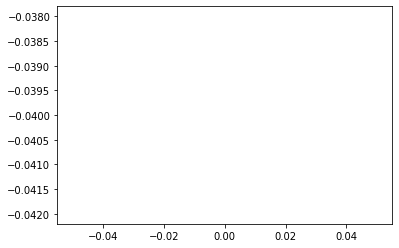

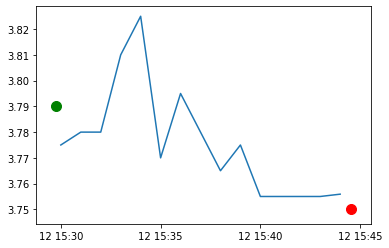

buy time:2020-02-12T15:29:46.233482189Z sell time:2020-02-12T15:44:33.386145743Z
{'rsi': 73.98673912353408, 'macd1': [0.00830520053681072, 0.010422679579965344, 0.01226603006015825, 0.014463913996945799, 0.016419932306429352], 'macd2': [0.021512856753454823, 0.021696436149419185, 0.02189141033795039, 0.022214908925098698, 0.022556976343462765], 'macd_signal': [0.007248859973911069, 0.007883623895121924, 0.008760105128129188, 0.00990086690189251, 0.011204679982799878]}
{'rsi': 44.78626458160033, 'macd': [0.003515217805460047, 0.0020940138809915076, 0.0009593872660680347, 6.280305617867299e-05, -0.0008963898743350462], 'bail_out': 0, 'too_close': 1, 'macd_signal': [0.0064760177172369805, 0.005599616949987886, 0.004671571013203916, 0.003749817421798867, 0.002820575962572084], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0037169658369071304}
YIN analysis for run 56


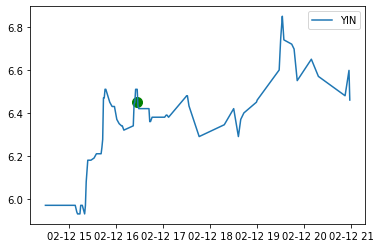

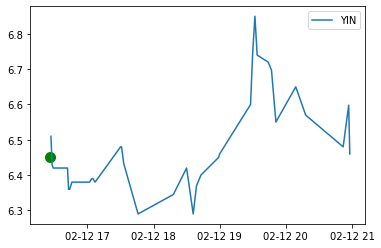

Delta = nan


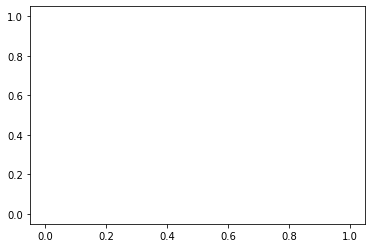

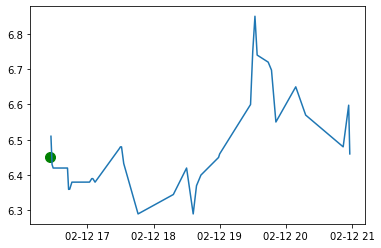

buy time:2020-02-12T16:26:25.829138848Z sell time:None
{'rsi': 69.37286681865137, 'macd1': [0.08966313683629856, 0.0802002366861343, 0.07346776236123453, 0.0753330002849033, 0.07673359409649638], 'macd2': [0.06559612969060247, 0.06538402397607523, 0.06540417937590348, 0.06691747839929363, 0.06836267277723174], 'macd_signal': [0.10356730192272676, 0.09889388887540826, 0.09380866357257352, 0.09011353091503947, 0.08743754355133085]}
None
ORBC analysis for run 56


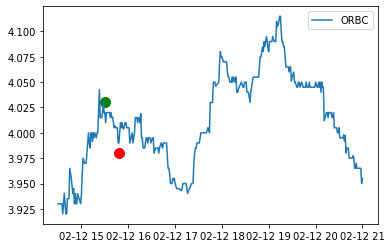

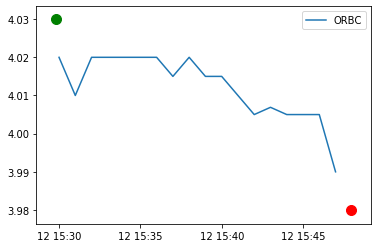

Delta = -0.050000000000000266


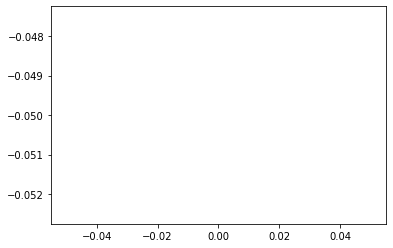

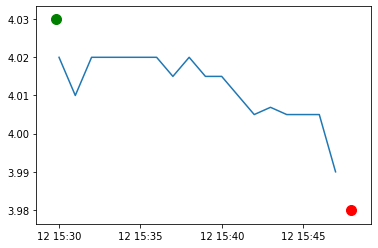

buy time:2020-02-12T15:29:49.594595713Z sell time:2020-02-12T15:47:58.349929809Z
{'rsi': 66.05377188814666, 'macd1': [0.020598193631159667, 0.01997732416537934, 0.01966208655925117, 0.019988756964030685, 0.020016903213200266], 'macd2': [0.01860739343092943, 0.01878819342550031, 0.019004454126742232, 0.019332961946434413, 0.019604279277632308], 'macd_signal': [0.02031967538615786, 0.020251205142002158, 0.02013338142545196, 0.020104456533167704, 0.020086945869174217]}
{'rsi': 36.1734465843399, 'macd': [0.0035039998393493477, 0.0028359842709368976, 0.002179920395927404, 0.0016403911375313385, -0.00010002635131645121], 'bail_out': 0, 'too_close': 1, 'macd_signal': [0.006078919817039186, 0.0054303327078187285, 0.004780250245440464, 0.004152278423858639, 0.003301817468823621], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.003401843820140072}
FINV analysis for run 56


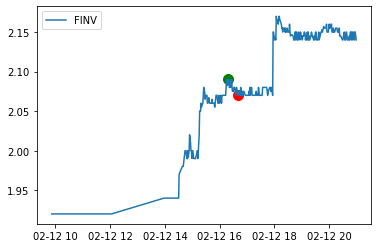

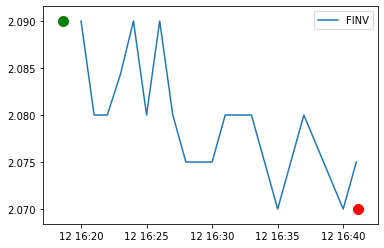

Delta = -0.020000000000000018


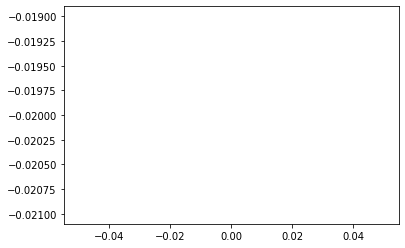

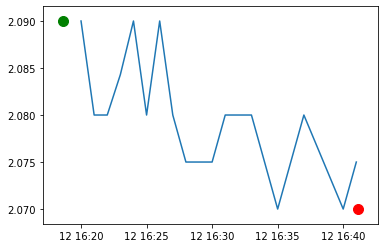

buy time:2020-02-12T16:18:35.469433248Z sell time:2020-02-12T16:41:05.466722008Z
{'rsi': 66.35632608398564, 'macd1': [0.004243479575865461, 0.005550767279152158, 0.006112878530682764, 0.006284186451048335, 0.006945077996051818], 'macd2': [0.010962195513098294, 0.011095966670190194, 0.011121325952792915, 0.011086886290840425, 0.011157420794112749], 'macd_signal': [0.0038174106309105523, 0.004164081960558874, 0.004553841274583652, 0.004899910309876588, 0.005308943847111634]}
{'rsi': 45.368258035491074, 'macd': [0.0011222155709362802, 0.0005162058684082815, 0.0005567670629527122, 6.166192801382309e-05, -0.0003249350852896349], 'bail_out': 0, 'too_close': 1, 'macd_signal': [0.0019348577307287437, 0.0016511273582646513, 0.0014322552992022636, 0.0011581366249645755, 0.0008615222829137334], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0011864573682033683}
PFNX analysis for run 56


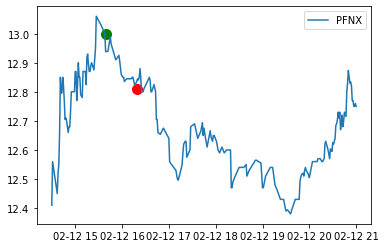

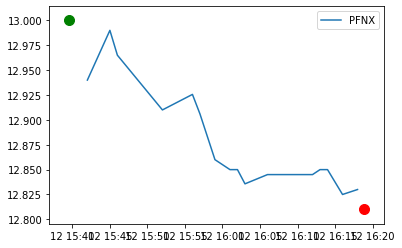

Delta = -0.1899999999999995


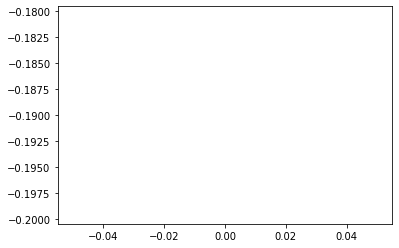

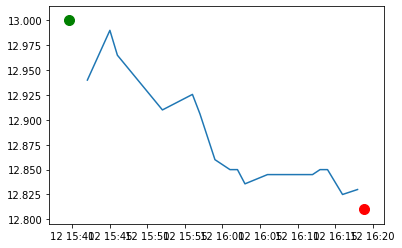

buy time:2020-02-12T15:39:32.907274367Z sell time:2020-02-12T16:18:52.366958009Z
{'rsi': 62.44335145991656, 'macd1': [0.04139986196801715, 0.044314183739002644, 0.054867408103859816, 0.06011717183012877, 0.06115197621019597], 'macd2': [0.041664342153010736, 0.04287836405895895, 0.04568602137577216, 0.04771627943274481, 0.04902805818978706], 'macd_signal': [0.048934272988579545, 0.048010255138664165, 0.0493816857317033, 0.051528782951388394, 0.053453421603149906]}
{'rsi': 39.5890977309706, 'macd': [-0.00560629189379469, -0.006738201663774035, -0.007532700164228245, -0.009352663928682503, -0.011688315382430758], 'bail_out': 0, 'too_close': 1, 'macd_signal': [0.006185171196265268, 0.003600496624257407, 0.001373857266560276, -0.0007714469724882799, -0.0029548206544767757], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.008733494727953983}


In [14]:
for run_id, count in runs.items():
    for symbol in minute_history:
        print (f'{symbol} analysis for run {run_id}')
        plt.plot(minute_history[symbol]['close'], label=symbol)


        for trade in trade_details[run_id][symbol]:
            plt.scatter(trade[0], trade[1], c='g', s=100)
            plt.scatter(trade[2], trade[3], c='r', s=100)

        plt.legend()
        plt.show()

        min_time = trade_details[run_id][symbol][0][0]
        max_time = trade_details[run_id][symbol][-1][2]
        delta = 0 
        accumulative_delta = []
        plt.plot(minute_history[symbol]['close'][min_time:max_time], label=symbol)
        for trade in trade_details[run_id][symbol]:
            plt.scatter(trade[0], trade[1], c='g', s=100)
            plt.scatter(trade[2], trade[3], c='r', s=100)
            trade_delta = trade[3] - trade[1]
            delta += trade_delta 
            accumulative_delta.append(delta)
        plt.legend()
        plt.show()

        print(f'Delta = {delta}')
        plt.plot(range(len(accumulative_delta)), accumulative_delta)
        plt.show()

        for trade in trade_details[run_id][symbol]:
            plt.plot(minute_history[symbol]['close'][trade[0]:trade[2]])
            plt.scatter(trade[0], trade[1], c='g', s=100)
            plt.scatter(trade[2], trade[3], c='r', s=100)
            plt.show()
            print(f"buy time:{trade[0]} sell time:{trade[2]}")
            print(trade[4])
            print(trade[5])
